<a href="https://colab.research.google.com/github/DKS2301/CNN-DBLSTM/blob/main/CNN_DBLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install -q scipy h5py matplotlib seaborn scikit-learn pandas numpy tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

TensorFlow version: 2.20.0
GPU Available: []


In [15]:
class MultiSOCBatteryDataLoader:
    """Load and preprocess REAL discharge-only battery data at 0/50/70/90% SOC"""

    def __init__(self, data_dir='battery_data'):
        self.data_dir = data_dir
        self.scaler = MinMaxScaler()
        self.battery_data = {}
        self.soc_levels = [50, 70, 90]  # Real SOC levels

    def load_csv_data(self, battery_name, soc_level):
        """
        Load discharge CSV for a specific battery and SOC level.
        File naming: sp{soc_level}_{battery}_discharge.csv
        """
        filename = f"sp{soc_level}_{battery_name}_discharge.csv"
        filepath = os.path.join(self.data_dir, filename)
        if not os.path.exists(filepath):
            raise FileNotFoundError(
                f"❌ Missing required data file: {filename}\n"
                f"Expected structure: {self.data_dir}/{filename}"
            )

        df = pd.read_csv(filepath)

        # Validate essential columns
        required_cols = {"cycle", "capacity"}
        if not required_cols.issubset(df.columns):
            raise ValueError(
                f"❌ {filename} is missing required columns: {required_cols}\n"
                f"Found columns: {df.columns.tolist()}"
            )

        print(f"✓ Loaded {filename}: {len(df)} cycles")

        # Add SOC and battery name
        df["soc_level"] = soc_level
        df["battery"] = battery_name

        return df

    def load_all_batteries(self, battery_names=['B0005', 'B0006', 'B0007', 'B0018']):
        """Load all batteries and SOC levels into a nested dict"""
        print("="*80)
        print("LOADING MULTI-SOC DISCHARGE DATA (REAL DATA ONLY)")
        print("="*80)

        for battery in battery_names:
            self.battery_data[battery] = {}
            for soc in self.soc_levels:
                df = self.load_csv_data(battery, soc)
                self.battery_data[battery][soc] = df

        return self.battery_data

    # ------------------ SOH & RUL CALCULATIONS ------------------

    def calculate_soh(self, capacity_series, initial_capacity=None):
        """Compute State of Health (%)"""
        if initial_capacity is None:
            initial_capacity = capacity_series.iloc[0]
        return (capacity_series / initial_capacity) * 100

    def calculate_rul(self, soh_series, failure_threshold=70):
        """Compute Remaining Useful Life per cycle"""
        rul = np.zeros(len(soh_series))

        for i in range(len(soh_series)):
            if soh_series.iloc[i] <= failure_threshold:
                rul[i] = 0
            else:
                # Check future cycles for threshold crossing
                below = soh_series.iloc[i:].le(failure_threshold)

                if below.any():
                    rul[i] = below.idxmax() - i
                else:
                    # Extrapolate degradation
                    if i < len(soh_series) - 1:
                        slope = (soh_series.iloc[i] - soh_series.iloc[-1]) / (len(soh_series) - i)
                        if slope > 0:
                            rul[i] = (soh_series.iloc[i] - failure_threshold) / slope
                        else:
                            rul[i] = len(soh_series) - i

        return rul

    # ------------------ SEQUENCE PREPARATION ------------------

    def prepare_sequences(self, data, seq_length=10, feature_cols=["capacity"]):
        """Generate input sequences & targets"""
        X, y = [], []

        for i in range(len(data) - seq_length):
            seq = data[feature_cols].iloc[i:i + seq_length].values
            target = data["capacity"].iloc[i + seq_length]

            X.append(seq)
            y.append(target)

        X = np.array(X)
        y = np.array(y)

        # Reshape: (N, seq_len, num_features)
        X = X.reshape(X.shape[0], seq_length, len(feature_cols))

        return X, y


In [16]:
# Initialize loader and load data
loader = MultiSOCBatteryDataLoader('')
battery_data = loader.load_all_batteries(['B0005', 'B0006', 'B0018', 'B0007']) # Calculate SOH and RUL for all batteries
all_soh_rul = {}
for battery in battery_data.keys():
  all_soh_rul[battery] = {}
  for soc in loader.soc_levels:
    df = battery_data[battery][soc]
    soh = loader.calculate_soh(df['capacity'])
    rul = loader.calculate_rul(soh)
    all_soh_rul[battery][soc] = { 'soh': soh, 'rul': rul, 'capacity': df['capacity'] }

LOADING MULTI-SOC DISCHARGE DATA (REAL DATA ONLY)
✓ Loaded sp50_B0005_discharge.csv: 168 cycles
✓ Loaded sp70_B0005_discharge.csv: 168 cycles
✓ Loaded sp90_B0005_discharge.csv: 168 cycles
✓ Loaded sp50_B0006_discharge.csv: 168 cycles
✓ Loaded sp70_B0006_discharge.csv: 168 cycles
✓ Loaded sp90_B0006_discharge.csv: 168 cycles
✓ Loaded sp50_B0018_discharge.csv: 132 cycles
✓ Loaded sp70_B0018_discharge.csv: 132 cycles
✓ Loaded sp90_B0018_discharge.csv: 132 cycles
✓ Loaded sp50_B0007_discharge.csv: 50 cycles
✓ Loaded sp70_B0007_discharge.csv: 71 cycles
✓ Loaded sp90_B0007_discharge.csv: 92 cycles



📊 Generating capacity degradation plots...


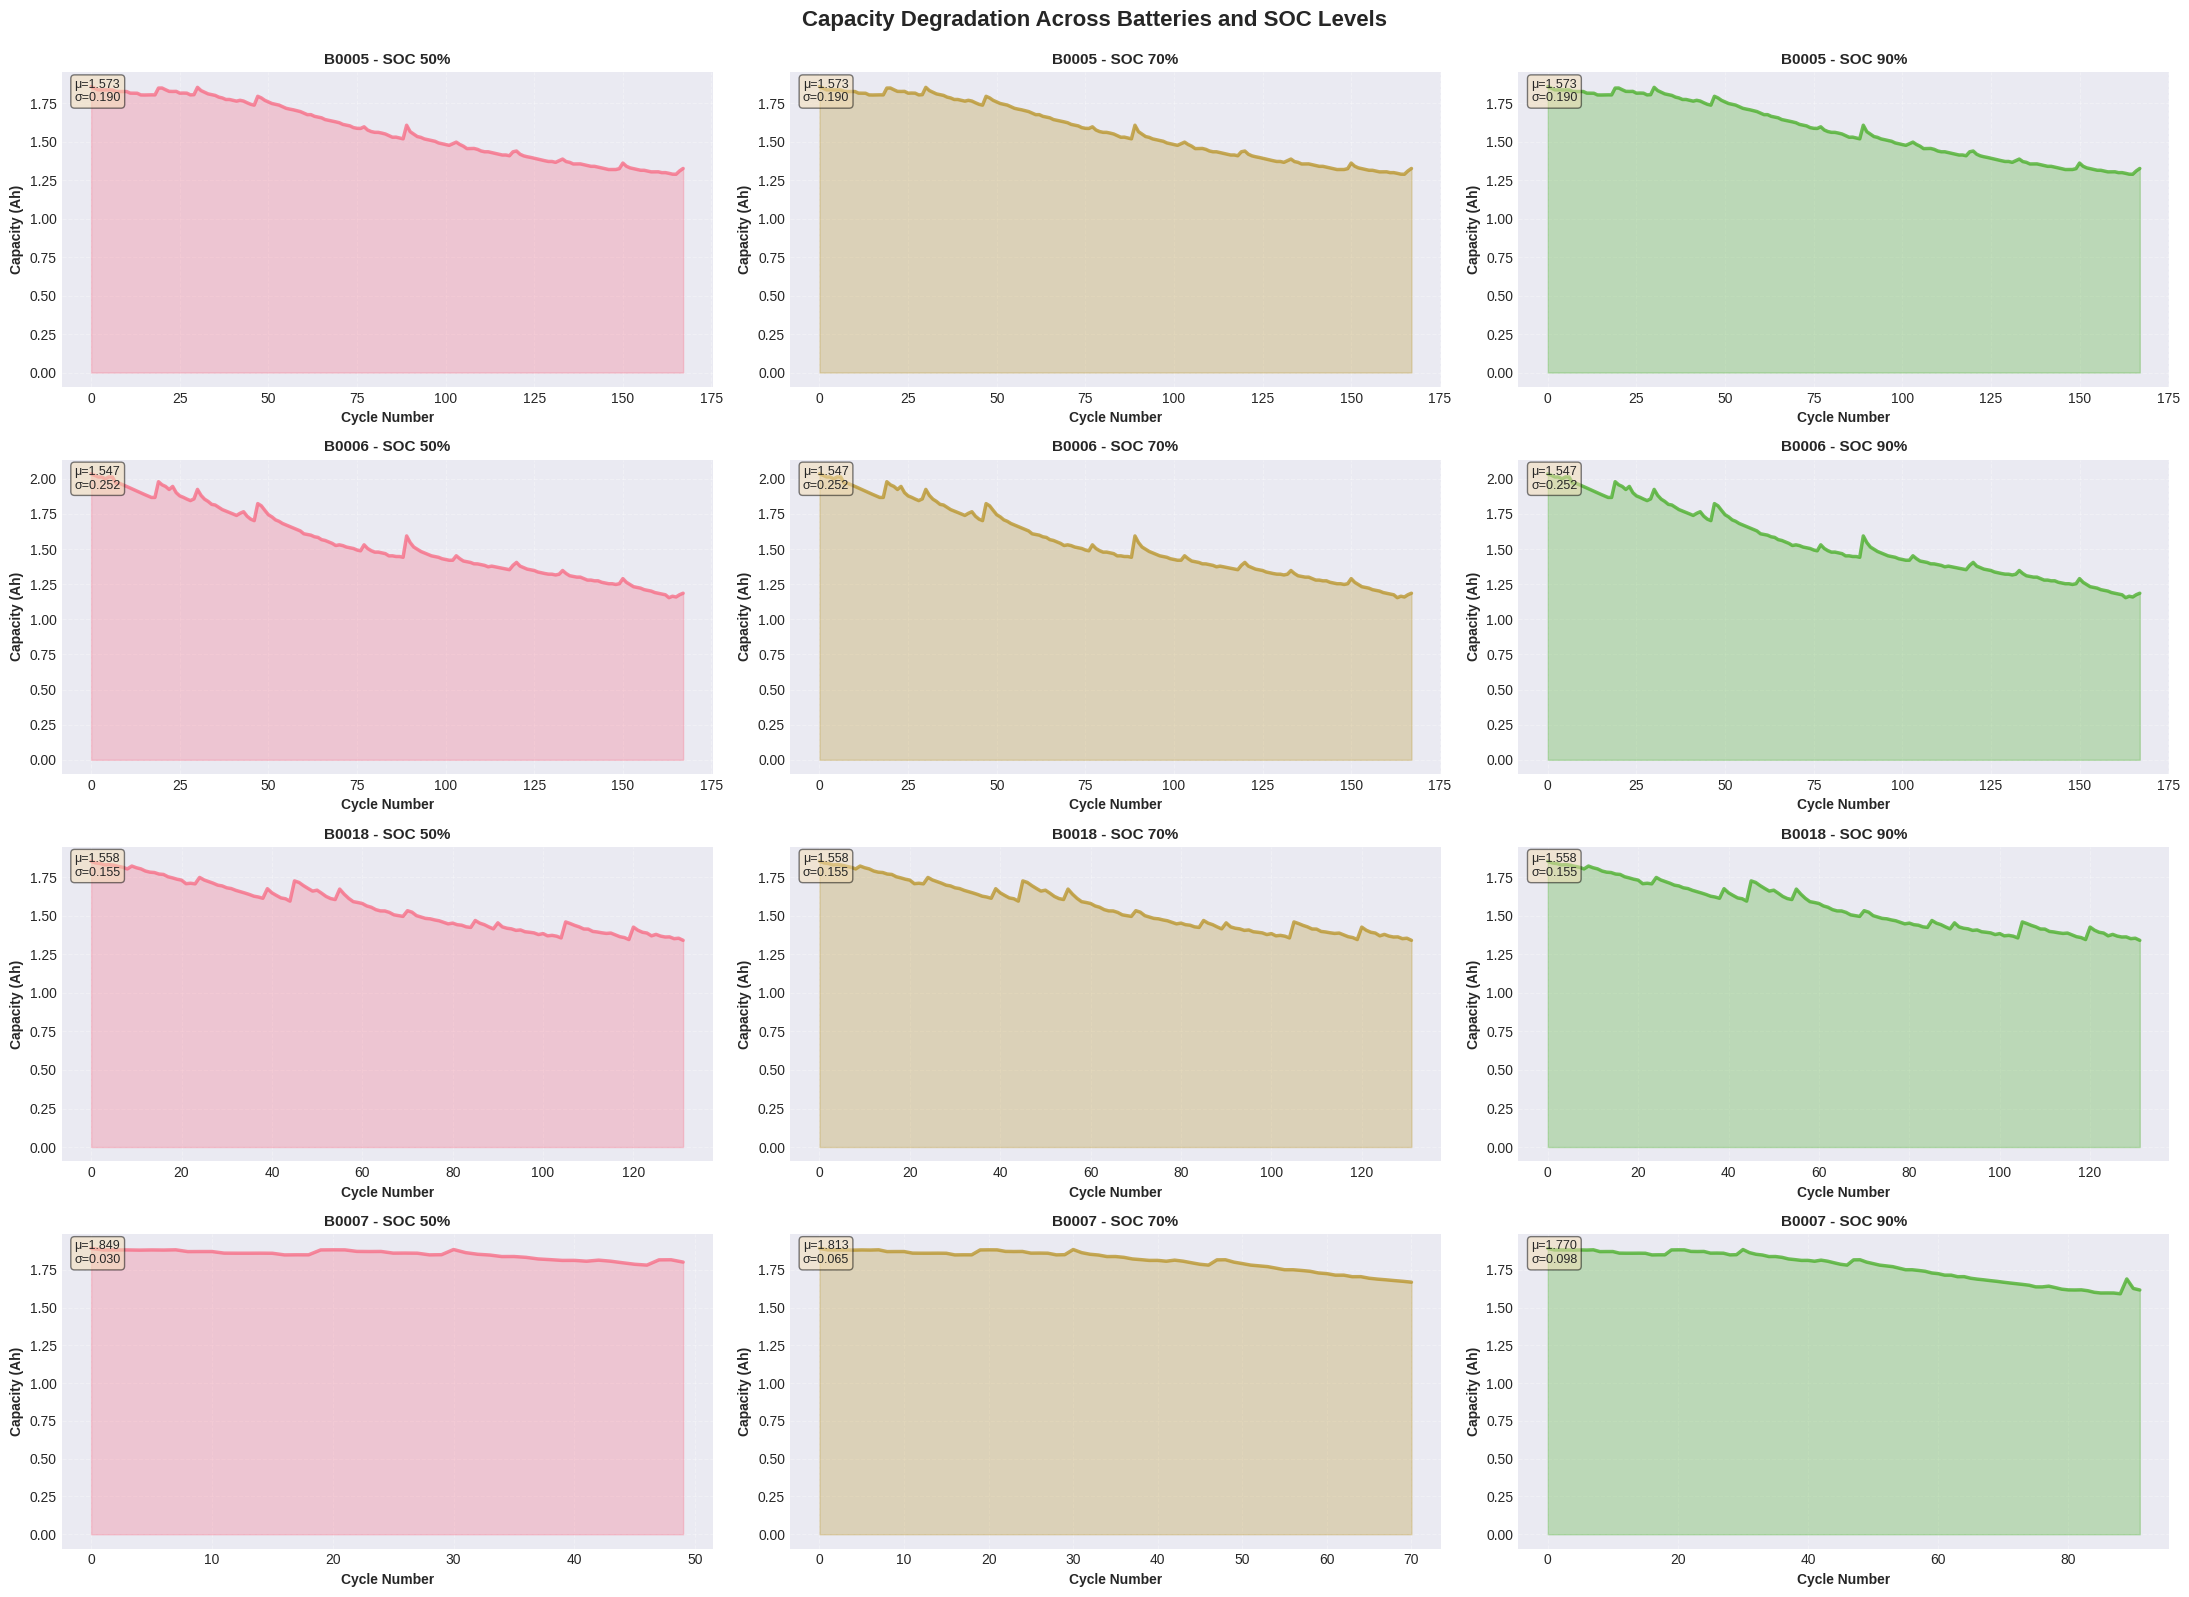

In [17]:
# VISUALIZATION 1: Capacity Degradation for All Batteries and SOC Levels
print("\n📊 Generating capacity degradation plots...")

fig, axes = plt.subplots(4, 3, figsize=(22, 16))   # <-- FIXED
fig.suptitle(
    'Capacity Degradation Across Batteries and SOC Levels',
    fontsize=16, fontweight='bold', y=0.995
)

for i, battery in enumerate(['B0005', 'B0006', 'B0018', 'B0007']):
    for j, soc in enumerate(loader.soc_levels):
        ax = axes[i, j]   # now valid because j ∈ {0,1,2,3}

        capacity = all_soh_rul[battery][soc]['capacity']
        cycles = np.arange(len(capacity))

        ax.plot(cycles, capacity, linewidth=2.5, alpha=0.8, color=f'C{j}')
        ax.fill_between(cycles, capacity, alpha=0.3, color=f'C{j}')

        ax.set_xlabel('Cycle Number', fontsize=10, fontweight='bold')
        ax.set_ylabel('Capacity (Ah)', fontsize=10, fontweight='bold')
        ax.set_title(f'{battery} - SOC {soc}%', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')

        ax.text(
            0.02, 0.98,
            f'μ={capacity.mean():.3f}\nσ={capacity.std():.3f}',
            transform=ax.transAxes,
            fontsize=9,
            va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        )

plt.tight_layout()
plt.savefig('01_capacity_degradation_all.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
print("\n" + "="*80)
print("DATA STATISTICS AND INSIGHTS")
print("="*80)

# Create comprehensive statistics table
stats_data = []

for battery in ['B0005', 'B0006', 'B0018', 'B0007']:
    for soc in loader.soc_levels:
        df = battery_data[battery][soc]
        soh = all_soh_rul[battery][soc]['soh']
        rul = all_soh_rul[battery][soc]['rul']

        stats_data.append({
            'Battery': battery,
            'SOC': f'{soc}%',
            'Cycles': len(df),
            'Initial Cap': df['capacity'].iloc[0],
            'Final Cap': df['capacity'].iloc[-1],
            'Cap Fade': df['capacity'].iloc[0] - df['capacity'].iloc[-1],
            'Initial SOH': soh.iloc[0],
            'Final SOH': soh.iloc[-1],
            'Avg RUL': rul.mean(),
            'SOH Std': soh.std()
        })

stats_df = pd.DataFrame(stats_data)
print("\n" + stats_df.to_string(index=False))

# Save statistics
stats_df.to_csv('battery_statistics.csv', index=False)
print("\n✓ Statistics saved to 'battery_statistics.csv'")

# Degradation rate analysis
print("\n" + "="*60)
print("DEGRADATION RATE ANALYSIS")
print("="*60)

for battery in ['B0005', 'B0006', 'B0018', 'B0007']:
    print(f"\n{battery}:")
    for soc in loader.soc_levels:
        soh = all_soh_rul[battery][soc]['soh']
        cycles = len(soh)
        degradation_rate = (soh.iloc[0] - soh.iloc[-1]) / cycles
        print(f"  SOC {soc}%: {degradation_rate:.4f}% per cycle")



DATA STATISTICS AND INSIGHTS

Battery SOC  Cycles  Initial Cap  Final Cap  Cap Fade  Initial SOH  Final SOH    Avg RUL   SOH Std
  B0005 50%     168     1.856487   1.325079  0.531408        100.0  71.375616  77.636905 10.256615
  B0005 70%     168     1.856487   1.325079  0.531408        100.0  71.375616  77.636905 10.256615
  B0005 90%     168     1.856487   1.325079  0.531408        100.0  71.375616  77.636905 10.256615
  B0006 50%     168     2.035338   1.185675  0.849662        100.0  58.254475  30.678571 12.383105
  B0006 70%     168     2.035338   1.185675  0.849662        100.0  58.254475  30.678571 12.383105
  B0006 90%     168     2.035338   1.185675  0.849662        100.0  58.254475  30.678571 12.383105
  B0018 50%     132     1.855005   1.341051  0.513953        100.0  72.293702  82.924122  8.349554
  B0018 70%     132     1.855005   1.341051  0.513953        100.0  72.293702  82.924122  8.349554
  B0018 90%     132     1.855005   1.341051  0.513953        100.0  72.293702 

In [19]:
print("\n" + "="*80)
print("BUILDING ENHANCED CNN-DBLSTM MODEL")
print("="*80)

class EnhancedCNN_DBLSTM:
    """Enhanced CNN-DBLSTM for multi-feature, multi-SOC battery RUL prediction"""

    def __init__(self, seq_length=20, n_features=1):
        self.seq_length = seq_length
        self.n_features = n_features
        self.model = None
        self.history = None

    def build_model(self, use_attention=False):
        """Build enhanced CNN-DBLSTM architecture"""

        inputs = layers.Input(shape=(self.seq_length, self.n_features),
                             name='input_layer')

        # ===== CNN Feature Extraction =====
        # First CNN block
        x = layers.Conv1D(filters=64, kernel_size=5, strides=1,
                         padding='same', name='conv1d_1')(inputs)
        x = layers.BatchNormalization(name='bn_1')(x)
        x = layers.LeakyReLU(alpha=0.01, name='leaky_relu_1')(x)
        x = layers.Dropout(0.2, name='dropout_1')(x)
        # Second CNN block
        x = layers.Conv1D(filters=128, kernel_size=3, strides=1,
                         padding='same', name='conv1d_2')(x)
        x = layers.BatchNormalization(name='bn_2')(x)
        x = layers.LeakyReLU(alpha=0.01, name='leaky_relu_2')(x)
        x = layers.Dropout(0.2, name='dropout_2')(x)

        # Third CNN block
        x = layers.Conv1D(filters=192, kernel_size=2, strides=1,
                         padding='same', name='conv1d_3')(x)
        x = layers.BatchNormalization(name='bn_3')(x)
        x = layers.LeakyReLU(alpha=0.01, name='leaky_relu_3')(x)

        # ===== Deep Bidirectional LSTM =====
        # First Bi-LSTM
        x = layers.Bidirectional(
            layers.LSTM(16, return_sequences=True, dropout=0.3,
                       recurrent_dropout=0.2, name='lstm_1'),
            name='bi_lstm_1'
        )(x)

        # Second Bi-LSTM
        x = layers.Bidirectional(
            layers.LSTM(16, return_sequences=False, dropout=0.3,
                       recurrent_dropout=0.2, name='lstm_2'),
            name='bi_lstm_2'
        )(x)

        # ===== Dense Layers =====
        x = layers.Dense(64, activation='relu', name='dense_1')(x)
        x = layers.Dropout(0.3, name='dropout_final')(x)
        x = layers.Dense(32, activation='relu', name='dense_2')(x)
        x = layers.Dense(16, activation='relu', name='dense_3')(x)

        # Output layer
        outputs = layers.Dense(1, activation='linear', name='output')(x)

        # Create model
        model = Model(inputs=inputs, outputs=outputs, name='CNN_DBLSTM_Enhanced')

        # Compile with Adam optimizer
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )

        self.model = model
        return model

# Build model
print("\n🔨 Building enhanced model...")
seq_length = 10
n_features = 1  # Using capacity only, can be expanded

enhanced_model = EnhancedCNN_DBLSTM(seq_length=seq_length, n_features=n_features)
model = enhanced_model.build_model()

print("\n📋 Model Architecture:")
model.summary()

# Visualize architecture
try:
    tf.keras.utils.plot_model(
        model,
        to_file='05_model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=200,
        expand_nested=True
    )
    print("\n✓ Model architecture diagram saved")
except:
    print("\n⚠ Could not save architecture diagram (GraphViz may not be installed)")

print("\n" + "="*80)
print("MODEL PARAMETERS")
print("="*80)
print(f"Total parameters: {model.count_params():,}")
print(f"Sequence length: {seq_length}")
print(f"Number of features: {n_features}")
print(f"Training batteries: B5, B6, B18")
print(f"Testing battery: B7")


BUILDING ENHANCED CNN-DBLSTM MODEL

🔨 Building enhanced model...

📋 Model Architecture:


Model: "CNN_DBLSTM_Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_1 (LeakyReLU)        │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 192)        │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 10, 192)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyReLU)        │ (None, 10, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_1 (Bidirectional)       │ (None, 10, 32)         │        26,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_2 (Bidirectional)       │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,729 (444.25 KB)

 Trainable params: 112,961 (441.25 KB)

 Non-trainable params: 768 (3.00 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

✓ Model architecture diagram saved

MODEL PARAMETERS
Total parameters: 113,729
Sequence length: 10
Number of features: 1
Training batteries: B5, B6, B18
Testing battery: B7



PREPARING DATA FOR CROSS-BATTERY VALIDATION
Training: B5, B6, B18 | Testing: B7

✓ Training data prepared:
  Shape: (612, 10, 1)
  Total samples: 612

✓ Test data prepared:
  Shape: (183, 10, 1)
  Total samples: 183

📊 Visualizing training data distribution...


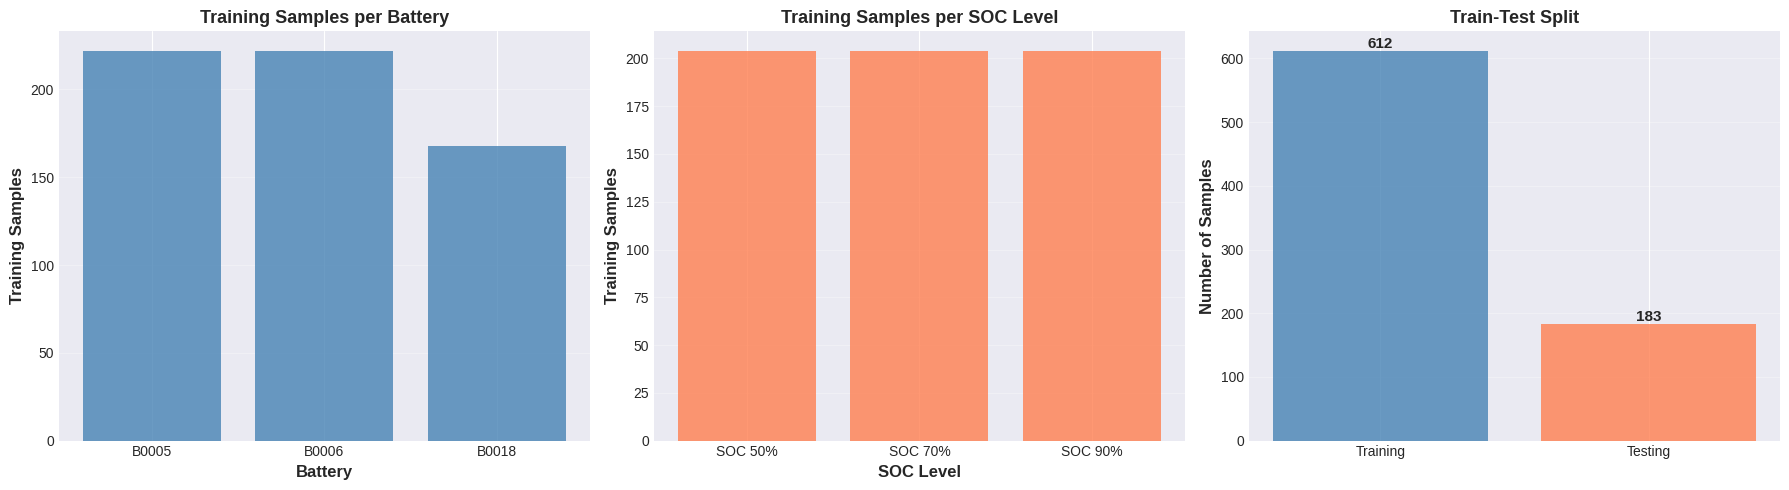

In [20]:
print("\n" + "="*80)
print("PREPARING DATA FOR CROSS-BATTERY VALIDATION")
print("Training: B5, B6, B18 | Testing: B7")
print("="*80)

def prepare_multi_battery_data(battery_data, train_batteries, test_battery,
                               soc_levels, seq_length=10,
                               feature_cols=['capacity']):
    """Prepare combined training and testing datasets"""

    X_train_all, y_train_all = [], []
    X_test_all, y_test_all = [], []
    train_info = []
    test_info = []

    # Prepare training data from multiple batteries
    for battery in train_batteries:
        for soc in soc_levels:
            df = battery_data[battery][soc].copy()

            # Split: first 50% for training, remaining for validation/test
            split_idx = len(df) // 2
            train_df = df.iloc[:split_idx]

            # Normalize
            scaler = MinMaxScaler()
            train_df_scaled = train_df.copy()
            train_df_scaled[feature_cols] = scaler.fit_transform(train_df[feature_cols])

            # Prepare sequences
            X, y = loader.prepare_sequences(train_df_scaled, seq_length, feature_cols)

            X_train_all.extend(X)
            y_train_all.extend(y)

            train_info.append({
                'battery': battery,
                'soc': soc,
                'samples': len(X),
                'cycles': len(train_df),
                'scaler': scaler
            })

    # Prepare test data from test battery
    for soc in soc_levels:
        df = battery_data[test_battery][soc].copy()

        # Normalize using own scaler
        scaler = MinMaxScaler()
        df_scaled = df.copy()
        df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

        # Prepare sequences
        X, y = loader.prepare_sequences(df_scaled, seq_length, feature_cols)

        X_test_all.extend(X)
        y_test_all.extend(y)

        test_info.append({
            'battery': test_battery,
            'soc': soc,
            'samples': len(X),
            'cycles': len(df),
            'scaler': scaler
        })

    X_train = np.array(X_train_all)
    y_train = np.array(y_train_all)
    X_test = np.array(X_test_all)
    y_test = np.array(y_test_all)

    print(f"\n✓ Training data prepared:")
    print(f"  Shape: {X_train.shape}")
    print(f"  Total samples: {len(X_train)}")

    print(f"\n✓ Test data prepared:")
    print(f"  Shape: {X_test.shape}")
    print(f"  Total samples: {len(X_test)}")

    return X_train, y_train, X_test, y_test, train_info, test_info

# Prepare data
train_batteries = ['B0005', 'B0006', 'B0018']
test_battery = 'B0007'

X_train, y_train, X_test, y_test, train_info, test_info = prepare_multi_battery_data(
    battery_data, train_batteries, test_battery,
    loader.soc_levels, seq_length=seq_length
)

# Training data distribution visualization
print("\n📊 Visualizing training data distribution...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training samples per battery
ax = axes[0]
train_counts = {}
for info in train_info:
    key = info['battery']
    train_counts[key] = train_counts.get(key, 0) + info['samples']

ax.bar(train_counts.keys(), train_counts.values(), color='steelblue', alpha=0.8)
ax.set_xlabel('Battery', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Samples', fontsize=12, fontweight='bold')
ax.set_title('Training Samples per Battery', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Training samples per SOC
ax = axes[1]
soc_counts = {}
for info in train_info:
    key = f"SOC {info['soc']}%"
    soc_counts[key] = soc_counts.get(key, 0) + info['samples']

ax.bar(soc_counts.keys(), soc_counts.values(), color='coral', alpha=0.8)
ax.set_xlabel('SOC Level', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Samples', fontsize=12, fontweight='bold')
ax.set_title('Training Samples per SOC Level', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Test vs Train comparison
ax = axes[2]
comparison = ['Training', 'Testing']
counts = [len(X_train), len(X_test)]
colors = ['steelblue', 'coral']

bars = ax.bar(comparison, counts, color=colors, alpha=0.8)
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Train-Test Split', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('06_data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print("\n" + "="*80)
print("TRAINING CNN-DBLSTM MODEL")
print("="*80)

# Create validation split
val_split = int(0.85 * len(X_train))
X_train_final = X_train[:val_split]
y_train_final = y_train[:val_split]
X_val = X_train[val_split:]
y_val = y_train[val_split:]

print(f"\nData splits:")
print(f"  Training: {len(X_train_final)} samples")
print(f"  Validation: {len(X_val)} samples")
print(f"  Testing: {len(X_test)} samples")

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# Train model
print("\n🚀 Starting training...")
print("="*60)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")


TRAINING CNN-DBLSTM MODEL

Data splits:
  Training: 520 samples
  Validation: 92 samples
  Testing: 183 samples

🚀 Starting training...
Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2334 - mae: 0.4049 - mse: 0.2334

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.2283 - mae: 0.3989 - mse: 0.2283 - val_loss: 0.0381 - val_mae: 0.1559 - val_mse: 0.0381 - learning_rate: 0.0010
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0316 - mae: 0.1414 - mse: 0.0316

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0314 - mae: 0.1409 - mse: 0.0314 - val_loss: 0.0353 - val_mae: 0.1503 - val_mse: 0.0353 - learning_rate: 0.0010
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0226 - mae: 0.1164 - mse: 0.0226 - val_loss: 0.0357 - val_mae: 0.1528 - val_mse: 0.0357 - learning_rate: 0.0010
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0164 - mae: 0.1009 - mse: 0.0164 - val_loss: 0.0363 - val_mae: 0.1555 - val_mse: 0.0363 - learning_rate: 0.0010
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0170 - mae: 0.1005 - mse: 0.0170 - val_loss: 0.0371 - val_mae: 0.1562 - val_mse: 0.0371 - learning_rate: 0.0010
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0145 - mae: 0.0955 - mse: 0.0145 - val_loss: 0.0380 - val_mae: 0.1568 - val_mse: 0.0380 - learning_rate: 0.0010
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0146 - mae: 0.0914 - mse: 0.0146 - val_loss: 0.0376 - val_mae: 0.1564 - val_mse:

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0101 - mae: 0.0775 - mse: 0.0101 - val_loss: 0.0340 - val_mae: 0.1499 - val_mse: 0.0340 - learning_rate: 5.0000e-04
Epoch 19/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0101 - mae: 0.0776 - mse: 0.0101

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0101 - mae: 0.0777 - mse: 0.0101 - val_loss: 0.0330 - val_mae: 0.1482 - val_mse: 0.0330 - learning_rate: 5.0000e-04
Epoch 20/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082 - mae: 0.0688 - mse: 0.0082

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0083 - mae: 0.0691 - mse: 0.0083 - val_loss: 0.0323 - val_mae: 0.1467 - val_mse: 0.0323 - learning_rate: 5.0000e-04
Epoch 21/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074 - mae: 0.0648 - mse: 0.0074

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0075 - mae: 0.0652 - mse: 0.0075 - val_loss: 0.0297 - val_mae: 0.1411 - val_mse: 0.0297 - learning_rate: 5.0000e-04
Epoch 22/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085 - mae: 0.0684 - mse: 0.0085

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0086 - mae: 0.0688 - mse: 0.0086 - val_loss: 0.0285 - val_mae: 0.1391 - val_mse: 0.0285 - learning_rate: 5.0000e-04
Epoch 23/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071 - mae: 0.0636 - mse: 0.0071

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0072 - mae: 0.0642 - mse: 0.0072 - val_loss: 0.0256 - val_mae: 0.1324 - val_mse: 0.0256 - learning_rate: 5.0000e-04
Epoch 24/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086 - mae: 0.0707 - mse: 0.0086 - val_loss: 0.0260 - val_mae: 0.1326 - val_mse: 0.0260 - learning_rate: 5.0000e-04
Epoch 25/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0079 - mae: 0.0664 - mse: 0.0079

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079 - mae: 0.0666 - mse: 0.0079 - val_loss: 0.0256 - val_mae: 0.1315 - val_mse: 0.0256 - learning_rate: 5.0000e-04
Epoch 26/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0078 - mae: 0.0650 - mse: 0.0078

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0078 - mae: 0.0650 - mse: 0.0078 - val_loss: 0.0226 - val_mae: 0.1239 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 27/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069 - mae: 0.0632 - mse: 0.0069

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0070 - mae: 0.0634 - mse: 0.0070 - val_loss: 0.0206 - val_mae: 0.1186 - val_mse: 0.0206 - learning_rate: 5.0000e-04
Epoch 28/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0078 - mae: 0.0688 - mse: 0.0078

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0078 - mae: 0.0687 - mse: 0.0078 - val_loss: 0.0188 - val_mae: 0.1135 - val_mse: 0.0188 - learning_rate: 5.0000e-04
Epoch 29/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070 - mae: 0.0620 - mse: 0.0070

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0070 - mae: 0.0622 - mse: 0.0070 - val_loss: 0.0161 - val_mae: 0.1047 - val_mse: 0.0161 - learning_rate: 5.0000e-04
Epoch 30/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0072 - mae: 0.0640 - mse: 0.0072 - val_loss: 0.0180 - val_mae: 0.1097 - val_mse: 0.0180 - learning_rate: 5.0000e-04
Epoch 31/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0592 - mse: 0.0064

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0065 - mae: 0.0595 - mse: 0.0065 - val_loss: 0.0157 - val_mae: 0.1024 - val_mse: 0.0157 - learning_rate: 5.0000e-04
Epoch 32/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 - mae: 0.0593 - mse: 0.0068

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0068 - mae: 0.0594 - mse: 0.0068 - val_loss: 0.0148 - val_mae: 0.0973 - val_mse: 0.0148 - learning_rate: 5.0000e-04
Epoch 33/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063 - mae: 0.0601 - mse: 0.0063

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0064 - mae: 0.0604 - mse: 0.0064 - val_loss: 0.0146 - val_mae: 0.0972 - val_mse: 0.0146 - learning_rate: 5.0000e-04
Epoch 34/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - mae: 0.0611 - mse: 0.0064

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0065 - mae: 0.0613 - mse: 0.0065 - val_loss: 0.0135 - val_mae: 0.0930 - val_mse: 0.0135 - learning_rate: 5.0000e-04
Epoch 35/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0068 - mae: 0.0639 - mse: 0.0068

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0068 - mae: 0.0640 - mse: 0.0068 - val_loss: 0.0135 - val_mae: 0.0929 - val_mse: 0.0135 - learning_rate: 5.0000e-04
Epoch 36/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0585 - mse: 0.0064

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0065 - mae: 0.0589 - mse: 0.0065 - val_loss: 0.0129 - val_mae: 0.0902 - val_mse: 0.0129 - learning_rate: 5.0000e-04
Epoch 37/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0050 - mae: 0.0518 - mse: 0.0050

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0052 - mae: 0.0532 - mse: 0.0052 - val_loss: 0.0109 - val_mae: 0.0815 - val_mse: 0.0109 - learning_rate: 5.0000e-04
Epoch 38/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - mae: 0.0656 - mse: 0.0073

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0074 - mae: 0.0656 - mse: 0.0074 - val_loss: 0.0105 - val_mae: 0.0787 - val_mse: 0.0105 - learning_rate: 5.0000e-04
Epoch 39/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0068 - mae: 0.0636 - mse: 0.0068 - val_loss: 0.0111 - val_mae: 0.0826 - val_mse: 0.0111 - learning_rate: 5.0000e-04
Epoch 40/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - mae: 0.0581 - mse: 0.0060

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0060 - mae: 0.0582 - mse: 0.0060 - val_loss: 0.0093 - val_mae: 0.0730 - val_mse: 0.0093 - learning_rate: 5.0000e-04
Epoch 41/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - mae: 0.0604 - mse: 0.0064

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0064 - mae: 0.0605 - mse: 0.0064 - val_loss: 0.0093 - val_mae: 0.0730 - val_mse: 0.0093 - learning_rate: 5.0000e-04
Epoch 42/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0060 - mae: 0.0566 - mse: 0.0060 - val_loss: 0.0095 - val_mae: 0.0722 - val_mse: 0.0095 - learning_rate: 5.0000e-04
Epoch 43/150
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0052 - mae: 0.0536 - mse: 0.0052

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0054 - mae: 0.0546 - mse: 0.0054 - val_loss: 0.0090 - val_mae: 0.0717 - val_mse: 0.0090 - learning_rate: 5.0000e-04
Epoch 44/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0059 - mae: 0.0575 - mse: 0.0059

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0059 - mae: 0.0573 - mse: 0.0059 - val_loss: 0.0084 - val_mae: 0.0622 - val_mse: 0.0084 - learning_rate: 5.0000e-04
Epoch 45/150
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0049 - mae: 0.0514 - mse: 0.0049

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0051 - mae: 0.0523 - mse: 0.0051 - val_loss: 0.0076 - val_mae: 0.0592 - val_mse: 0.0076 - learning_rate: 5.0000e-04
Epoch 46/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0051 - mae: 0.0529 - mse: 0.0051 - val_loss: 0.0085 - val_mae: 0.0664 - val_mse: 0.0085 - learning_rate: 5.0000e-04
Epoch 47/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054 - mae: 0.0542 - mse: 0.0054 - val_loss: 0.0083 - val_mae: 0.0627 - val_mse: 0.0083 - learning_rate: 5.0000e-04
Epoch 48/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0057 - mae: 0.0547 - mse: 0.0057 - val_loss: 0.0078 - val_mae: 0.0600 - val_mse: 0.0078 - learning_rate: 5.0000e-04
Epoch 49/150
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0060 - mae: 0.0582 - mse: 0.0060

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0061 - mae: 0.0585 - mse: 0.0061 - val_loss: 0.0073 - val_mae: 0.0567 - val_mse: 0.0073 - learning_rate: 5.0000e-04
Epoch 50/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052 - mae: 0.0546 - mse: 0.0052 - val_loss: 0.0076 - val_mae: 0.0602 - val_mse: 0.0076 - learning_rate: 5.0000e-04
Epoch 51/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0054 - mae: 0.0541 - mse: 0.0054

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0055 - mae: 0.0545 - mse: 0.0055 - val_loss: 0.0071 - val_mae: 0.0577 - val_mse: 0.0071 - learning_rate: 5.0000e-04
Epoch 52/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047 - mae: 0.0514 - mse: 0.0047 - val_loss: 0.0072 - val_mae: 0.0555 - val_mse: 0.0072 - learning_rate: 5.0000e-04
Epoch 53/150
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0055 - mae: 0.0544 - mse: 0.0055

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0056 - mae: 0.0547 - mse: 0.0056 - val_loss: 0.0070 - val_mae: 0.0551 - val_mse: 0.0070 - learning_rate: 5.0000e-04
Epoch 54/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052 - mae: 0.0535 - mse: 0.0052 - val_loss: 0.0074 - val_mae: 0.0584 - val_mse: 0.0074 - learning_rate: 5.0000e-04
Epoch 55/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049 - mae: 0.0503 - mse: 0.0049 - val_loss: 0.0076 - val_mae: 0.0602 - val_mse: 0.0076 - learning_rate: 5.0000e-04
Epoch 56/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0048 - mae: 0.0502 - mse: 0.0048 - val_loss: 0.0072 - val_mae: 0.0564 - val_mse: 0.0072 - learning_rate: 5.0000e-04
Epoch 57/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - mae: 0.0543 - mse: 0.0056

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0057 - mae: 0.0546 - mse: 0.0057 - val_loss: 0.0064 - val_mae: 0.0497 - val_mse: 0.0064 - learning_rate: 5.0000e-04
Epoch 58/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060 - mae: 0.0581 - mse: 0.0060 - val_loss: 0.0068 - val_mae: 0.0564 - val_mse: 0.0068 - learning_rate: 5.0000e-04
Epoch 59/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047 - mae: 0.0502 - mse: 0.0047 - val_loss: 0.0069 - val_mae: 0.0567 - val_mse: 0.0069 - learning_rate: 5.0000e-04
Epoch 60/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052 - mae: 0.0534 - mse: 0.0052 - val_loss: 0.0068 - val_mae: 0.0548 - val_mse: 0.0068 - learning_rate: 5.0000e-04
Epoch 61/150
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045 - mae: 0.0493 - mse: 0.0045

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046 - mae: 0.0496 - mse: 0.0046 - val_loss: 0.0063 - val_mae: 0.0480 - val_mse: 0.0063 - learning_rate: 5.0000e-04
Epoch 62/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054 - mae: 0.0550 - mse: 0.0054 - val_loss: 0.0074 - val_mae: 0.0601 - val_mse: 0.0074 - learning_rate: 5.0000e-04
Epoch 63/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042 - mae: 0.0478 - mse: 0.0042 - val_loss: 0.0075 - val_mae: 0.0609 - val_mse: 0.0075 - learning_rate: 5.0000e-04
Epoch 64/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044 - mae: 0.0503 - mse: 0.0044 - val_loss: 0.0079 - val_mae: 0.0627 - val_mse: 0.0079 - learning_rate: 5.0000e-04
Epoch 65/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053 - mae: 0.0554 - mse: 0.0053 - val_loss: 0.0076 - val_mae: 0.0603 - val_mse: 0.0076 - learning_rate: 5.0000e-04
Epoch 66/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047 - mae: 0.0499 - mse: 0.0047 - val_loss: 0.0073 - v


📊 Visualizing training history...


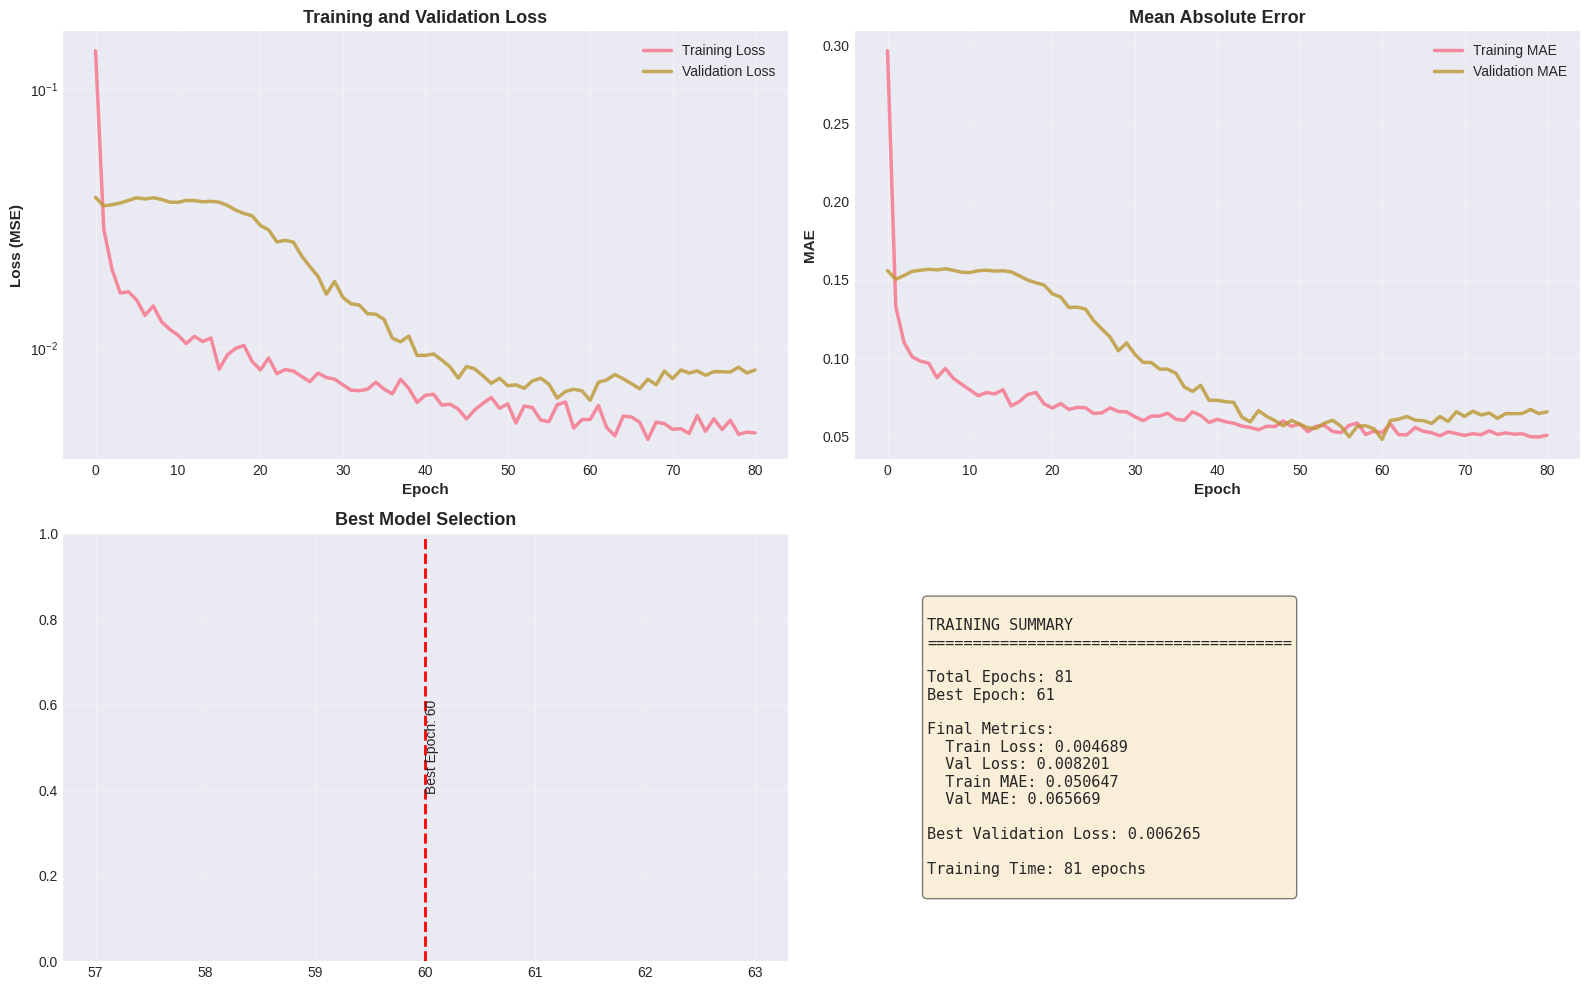

In [22]:

print("\n📊 Visualizing training history...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Loss curves
ax = axes[0, 0]
ax.plot(history.history['loss'], label='Training Loss', linewidth=2.5, alpha=0.8)
ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, alpha=0.8)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Loss (MSE)', fontsize=11, fontweight='bold')
ax.set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# MAE curves
ax = axes[0, 1]
ax.plot(history.history['mae'], label='Training MAE', linewidth=2.5, alpha=0.8)
ax.plot(history.history['val_mae'], label='Validation MAE', linewidth=2.5, alpha=0.8)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('MAE', fontsize=11, fontweight='bold')
ax.set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Learning rate (if available)
ax = axes[1, 0]
if 'lr' in history.history:
    ax.plot(history.history['lr'], linewidth=2.5, color='green', alpha=0.8)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
    ax.set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
    ax.set_yscale('log')
else:
    epoch_min_val_loss = np.argmin(history.history['val_loss'])
    ax.axvline(x=epoch_min_val_loss, color='red', linestyle='--', linewidth=2)
    ax.text(epoch_min_val_loss, 0.5, f'Best Epoch: {epoch_min_val_loss}',
            rotation=90, verticalalignment='center', fontsize=10)
    ax.set_title('Best Model Selection', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Training summary statistics
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""
TRAINING SUMMARY
{'='*40}

Total Epochs: {len(history.history['loss'])}
Best Epoch: {np.argmin(history.history['val_loss']) + 1}

Final Metrics:
  Train Loss: {history.history['loss'][-1]:.6f}
  Val Loss: {history.history['val_loss'][-1]:.6f}
  Train MAE: {history.history['mae'][-1]:.6f}
  Val MAE: {history.history['val_mae'][-1]:.6f}

Best Validation Loss: {min(history.history['val_loss']):.6f}

Training Time: {len(history.history['loss'])} epochs
"""

ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round',
        facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('07_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
print("\n" + "="*80)
print("GENERATING PREDICTIONS AND EVALUATIONS")
print("="*80)

# Make predictions
print("\n🔮 Generating predictions...")
y_pred_train = model.predict(X_train_final, verbose=0).flatten()
y_pred_val = model.predict(X_val, verbose=0).flatten()
y_pred_test = model.predict(X_test, verbose=0).flatten()

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    max_error = np.max(np.abs(y_true - y_pred))

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Max Error': max_error
    }

# Calculate metrics for all sets
train_metrics = calculate_metrics(y_train_final, y_pred_train)
val_metrics = calculate_metrics(y_val, y_pred_val)
test_metrics = calculate_metrics(y_test, y_pred_test)

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)

metrics_comparison = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'MAPE (%)', 'Max Error'],
    'Training': [train_metrics['RMSE'], train_metrics['MAE'],
                train_metrics['R2'], train_metrics['MAPE'],
                train_metrics['Max Error']],
    'Validation': [val_metrics['RMSE'], val_metrics['MAE'],
                  val_metrics['R2'], val_metrics['MAPE'],
                  val_metrics['Max Error']],
    'Testing': [test_metrics['RMSE'], test_metrics['MAE'],
               test_metrics['R2'], test_metrics['MAPE'],
               test_metrics['Max Error']]
})

print("\n" + metrics_comparison.to_string(index=False))

# Save metrics
metrics_comparison.to_csv('model_performance_metrics.csv', index=False)
print("\n✓ Metrics saved to 'model_performance_metrics.csv'")



GENERATING PREDICTIONS AND EVALUATIONS

🔮 Generating predictions...

PERFORMANCE METRICS

   Metric     Training   Validation      Testing
     RMSE 6.584480e-02 7.915241e-02 8.833634e-02
      MAE 4.476012e-02 4.799150e-02 6.337575e-02
       R² 9.460532e-01 8.513569e-01 9.095557e-01
 MAPE (%) 4.620063e+08 1.264706e+09 1.017722e+09
Max Error 3.444619e-01 3.444619e-01 3.310972e-01

✓ Metrics saved to 'model_performance_metrics.csv'



📊 Generating prediction visualizations...


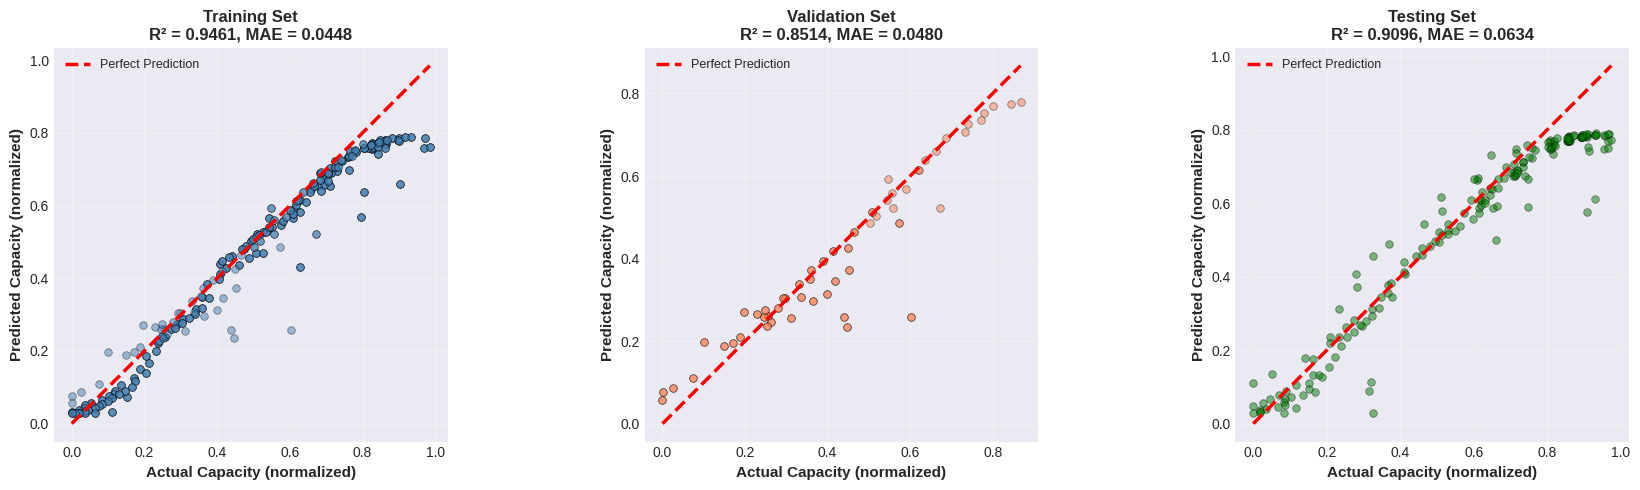

In [24]:

print("\n📊 Generating prediction visualizations...")

# Scatter plots: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    ('Training', y_train_final, y_pred_train, 'steelblue'),
    ('Validation', y_val, y_pred_val, 'coral'),
    ('Testing', y_test, y_pred_test, 'green')
]

for idx, (name, y_true, y_pred, color) in enumerate(datasets):
    ax = axes[idx]

    ax.scatter(y_true, y_pred, alpha=0.5, s=30, color=color, edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5, label='Perfect Prediction')

    # Calculate R²
    if name == 'Training':
        r2 = train_metrics['R2']
        mae = train_metrics['MAE']
    elif name == 'Validation':
        r2 = val_metrics['R2']
        mae = val_metrics['MAE']
    else:
        r2 = test_metrics['R2']
        mae = test_metrics['MAE']

    ax.set_xlabel('Actual Capacity (normalized)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Capacity (normalized)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} Set\nR² = {r2:.4f}, MAE = {mae:.4f}',
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('08_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


ADDITIONAL VISUALIZATIONS: PREDICTIONS vs CYCLE, RESIDUALS, PER-SOC METRICS

Plotting test predictions for B0007 SOC 50% (samples: 40)


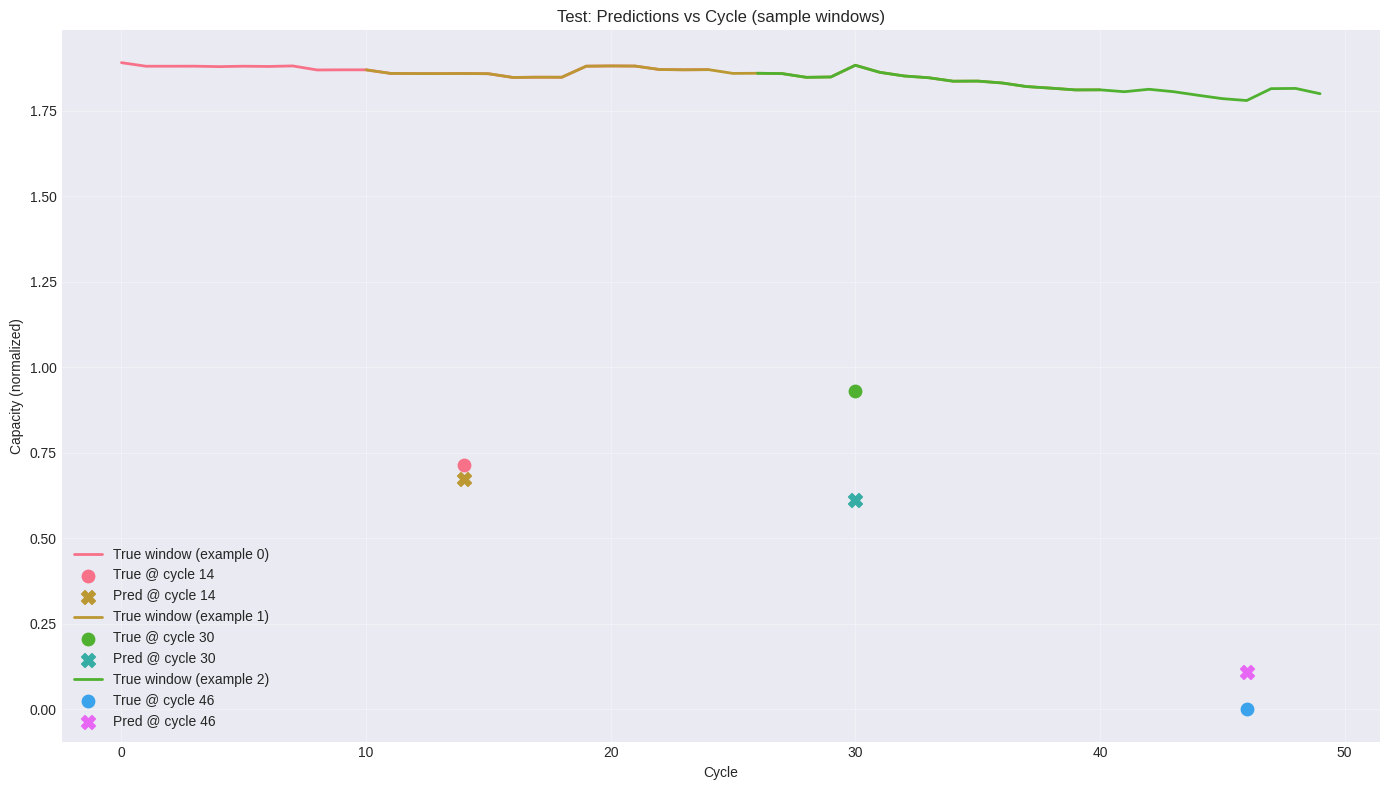


Plotting test predictions for B0007 SOC 70% (samples: 61)


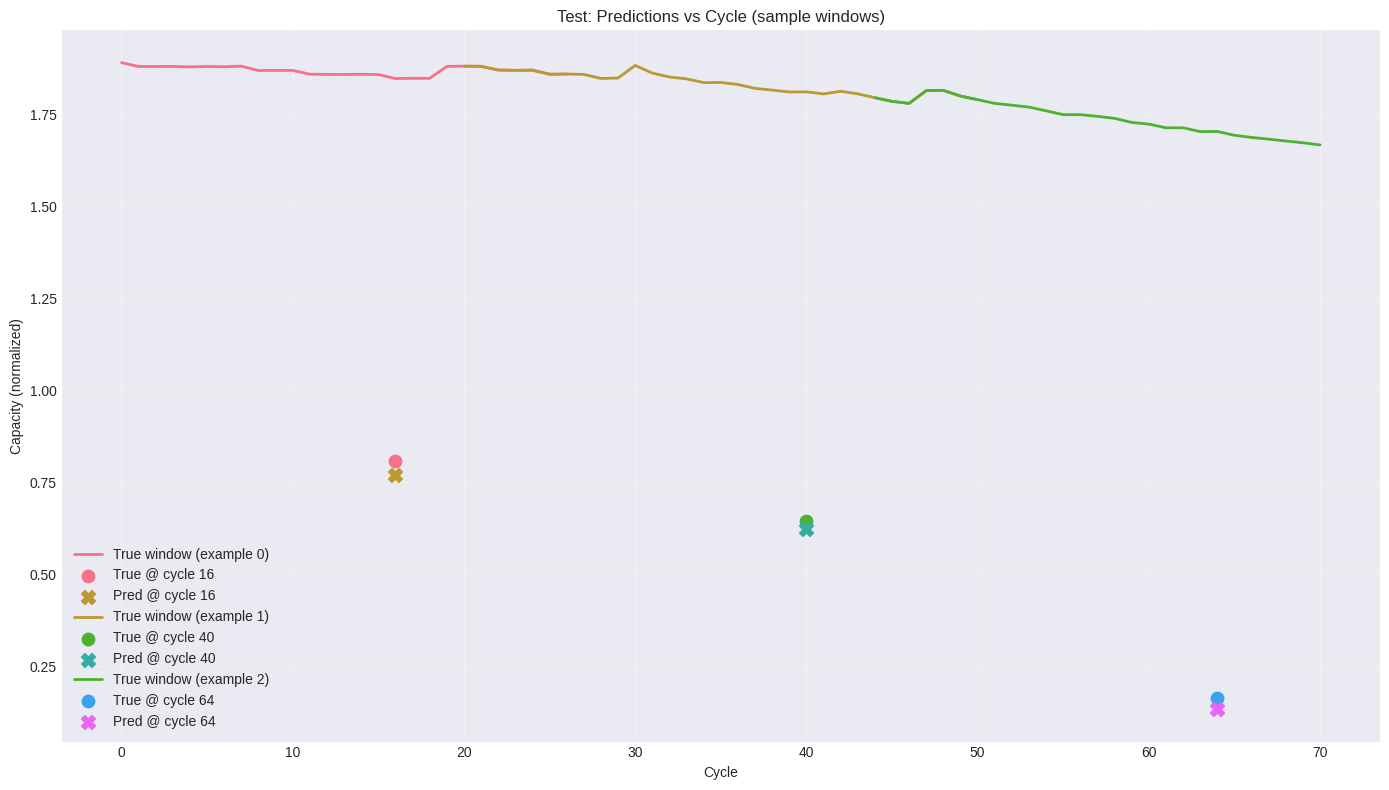


Plotting test predictions for B0007 SOC 90% (samples: 82)


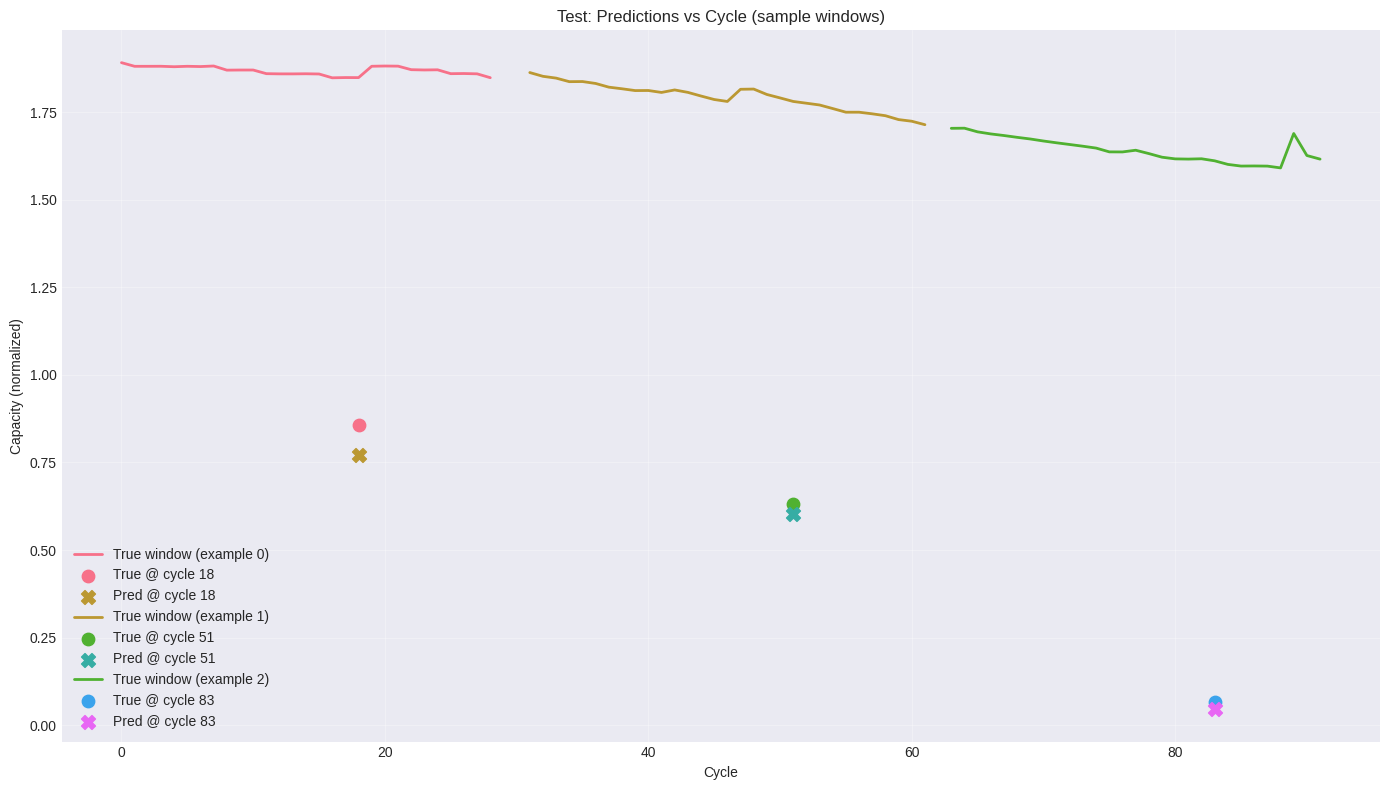

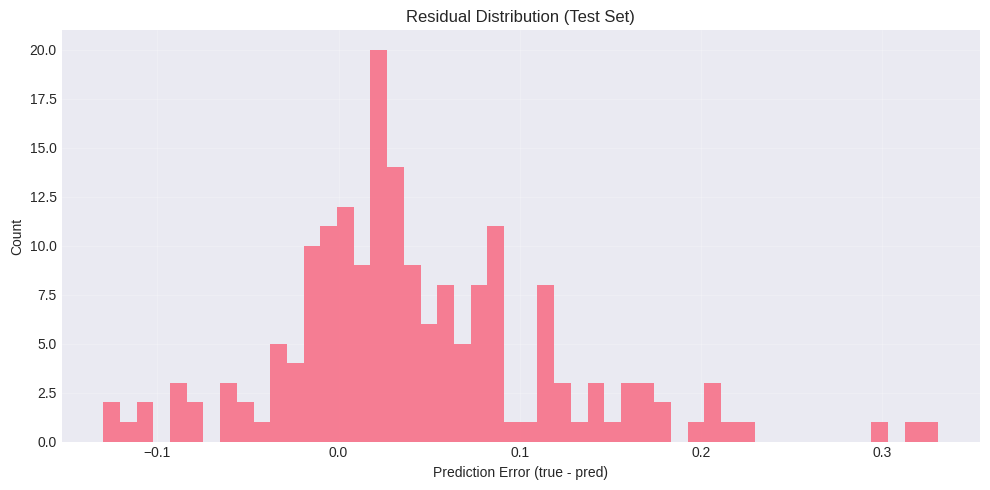

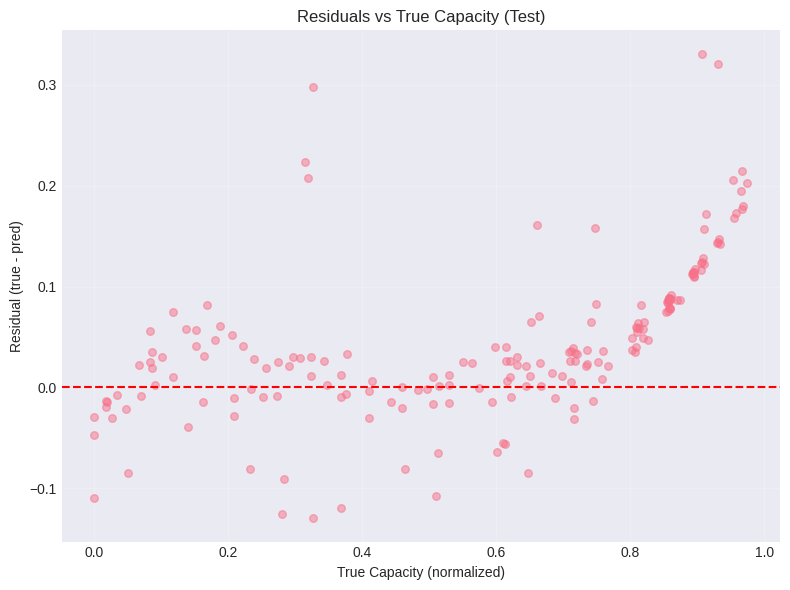


Per-SOC Test Metrics (B7):
 SOC  Samples     RMSE      MAE       R2
  50       40 0.113083 0.083271 0.800722
  70       61 0.074342 0.051512 0.931711
  90       82 0.084056 0.062496 0.929318

✓ Per-SOC metrics saved to 'per_soc_test_metrics.csv'


In [25]:

print("\n" + "="*80)
print("ADDITIONAL VISUALIZATIONS: PREDICTIONS vs CYCLE, RESIDUALS, PER-SOC METRICS")
print("="*80)

# Helper to plot predictions over cycles for a selection of SOCs from test battery
def plot_predictions_over_cycles(X_sequences, y_true, y_pred, original_df, seq_length=seq_length, n_examples=3, title_prefix='Test'):
    """
    X_sequences: sequence input array (N, seq_length, features)
    y_true, y_pred: arrays of scalar (length N)
    original_df: original unscaled dataframe for that SOC used to build sequences
    """
    N = len(y_true)
    # pick a few random indices but constrained to early/mid/late phases
    idxs = [int(N*0.1), int(N*0.5), int(N*0.9)]
    plt.figure(figsize=(14, 8))

    for i, idx in enumerate(idxs[:n_examples]):
        # map sequence end to cycle index in original df: sequence ends at idx + seq_length
        cycle_idx = idx + seq_length
        # show local window of cycles
        start = max(0, cycle_idx - seq_length - 10)
        end = min(len(original_df)-1, cycle_idx + 10)
        cycles = np.arange(start, end + 1)

        # true capacity from original df for that window
        true_window = original_df['capacity'].values[start:end+1]

        # predicted scalar belongs to point cycle_idx
        pred_point = y_pred[idx]
        true_point = y_true[idx]

        plt.plot(cycles, true_window, label=f'True window (example {i})', linewidth=2)
        plt.scatter([cycle_idx], [true_point], marker='o', s=80, label=f'True @ cycle {cycle_idx}')
        plt.scatter([cycle_idx], [pred_point], marker='X', s=100, label=f'Pred @ cycle {cycle_idx}')

    plt.xlabel('Cycle')
    plt.ylabel('Capacity (normalized)')
    plt.title(f'{title_prefix}: Predictions vs Cycle (sample windows)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot examples from each SOC in test battery (B7)
for soc in loader.soc_levels:
    df_test = battery_data[test_battery][soc].copy()
    scaler = [t['scaler'] for t in test_info if t['soc'] == soc][0]
    # Build sequences same way as used earlier (must match prepare_sequences on scaled df)
    df_scaled = df_test.copy()
    df_scaled[['capacity']] = scaler.transform(df_scaled[['capacity']])
    X_seq, y_seq = loader.prepare_sequences(df_scaled, seq_length=seq_length, feature_cols=['capacity'])
    # find indices in global X_test matching this SOC (simple approach: use ordering used in prepare_multi_battery_data)
    # We'll slice from local arrays: we previously concatenated test sequences in the prepare function in SOC order,
    # so we can reconstruct lengths per SOC from test_info.
    soc_entry = next((t for t in test_info if t['soc'] == soc), None)
    if soc_entry is None:
        continue
    samples = soc_entry['samples']
    # compute offset
    offset = sum([t['samples'] for t in test_info if t['soc'] < soc])
    y_true_local = y_test[offset:offset+samples]
    y_pred_local = y_pred_test[offset:offset+samples]
    print(f"\nPlotting test predictions for {test_battery} SOC {soc}% (samples: {samples})")
    plot_predictions_over_cycles(None, y_true_local, y_pred_local, df_test, seq_length=seq_length)

# Residual analysis aggregated
residuals_test = y_test - y_pred_test
plt.figure(figsize=(10,5))
plt.hist(residuals_test, bins=50, alpha=0.9)
plt.title('Residual Distribution (Test Set)')
plt.xlabel('Prediction Error (true - pred)')
plt.ylabel('Count')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Residuals vs True
plt.figure(figsize=(8,6))
plt.scatter(y_test, residuals_test, alpha=0.5, s=30)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Capacity (normalized)')
plt.ylabel('Residual (true - pred)')
plt.title('Residuals vs True Capacity (Test)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Per-SOC performance table for the test battery
per_soc_rows = []
offset = 0
for entry in test_info:
    n = entry['samples']
    if n == 0:
        per_soc_rows.append({
            'SOC': entry['soc'],
            'Samples': 0,
            'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan
        })
        continue
    y_t = y_test[offset:offset+n]
    y_p = y_pred_test[offset:offset+n]
    m = calculate_metrics(y_t, y_p)
    per_soc_rows.append({
        'SOC': entry['soc'],
        'Samples': n,
        'RMSE': m['RMSE'],
        'MAE': m['MAE'],
        'R2': m['R2']
    })
    offset += n

per_soc_df = pd.DataFrame(per_soc_rows)
print("\nPer-SOC Test Metrics (B7):")
print(per_soc_df.to_string(index=False))
per_soc_df.to_csv('per_soc_test_metrics.csv', index=False)
print("\n✓ Per-SOC metrics saved to 'per_soc_test_metrics.csv'")



ESTIMATE RUL FROM PREDICTED CAPACITY AND EVALUATE RUL METRICS


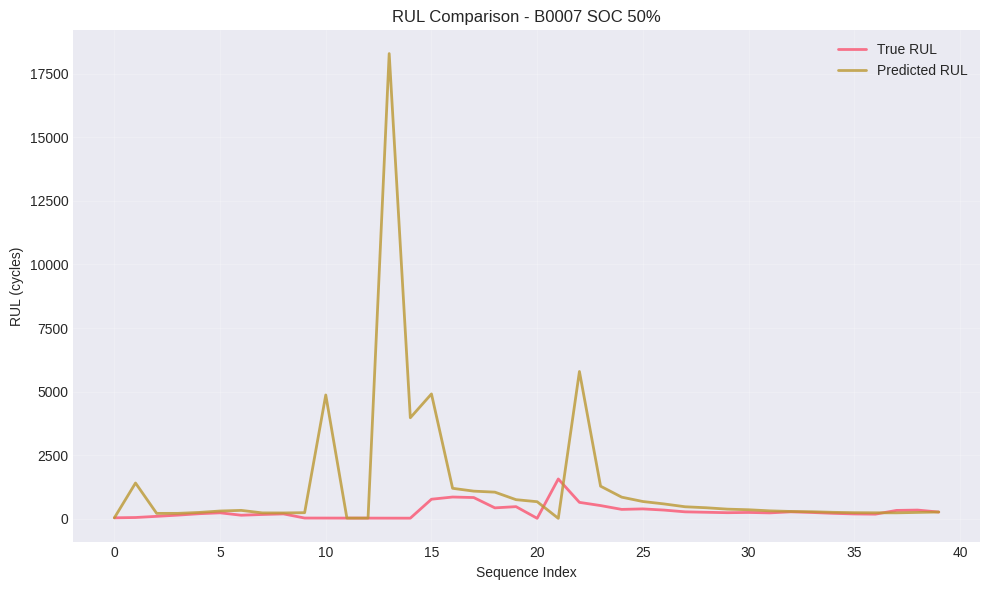


RUL Estimation Metrics (per SOC):
 SOC  Samples     RUL_MAE     RUL_RMSE
  50       40 1126.155856  3250.863347
  70       61 2694.116902 13427.762653
  90       82 3917.260913 26926.877354

✓ RUL metrics saved to 'rul_estimation_metrics.csv'

Aggregate RUL MAE: 2579.1779, Aggregate RUL RMSE: 14535.1678


In [26]:

print("\n" + "="*80)
print("ESTIMATE RUL FROM PREDICTED CAPACITY AND EVALUATE RUL METRICS")
print("="*80)

def capacity_to_soh(capacity_array, initial_capacity):
    """Convert capacity to SOH percentage"""
    return (capacity_array / initial_capacity) * 100

def compute_rul_from_soh(soh_array, failure_threshold=70):
    """
    For each cycle index i, RUL = cycles until soh <= threshold.
    If never crosses threshold, do linear extrapolation using simple slope computed from series.
    Returns an array of same length.
    """
    rul = np.zeros_like(soh_array)
    n = len(soh_array)
    for i in range(n):
        if soh_array[i] <= failure_threshold:
            rul[i] = 0
        else:
            future = soh_array[i:]
            below = np.where(future <= failure_threshold)[0]
            if below.size > 0:
                rul[i] = below[0]
            else:
                # linear extrapolation using average degradation per step from start to i
                if i == 0:
                    rul[i] = n - i
                else:
                    # slope (per step) estimated using first to current
                    slope = (soh_array[0] - soh_array[i]) / max(1, i)
                    if slope <= 0:
                        rul[i] = n - i
                    else:
                        rul[i] = max(0, (soh_array[i] - failure_threshold) / slope)
    return rul

# Evaluate RUL for test battery per SOC and aggregate metrics
rul_metrics_rows = []
offset = 0
for entry in test_info:
    n = entry['samples']
    soc = entry['soc']
    df_test = battery_data[test_battery][soc].copy()
    initial_cap = df_test['capacity'].iloc[0]
    # sequences -> cycles mapping: y_test holds predicted capacity (normalized? we used MinMax scalers per SOC),
    # but y_test was on scaled data. We must inverse-transform per-SOC to absolute capacity before converting to SOH.
    scaler = entry['scaler']
    # take raw predicted scaled values and inverse transform
    y_pred_scaled = y_pred_test[offset:offset+n].reshape(-1,1)
    y_true_scaled = y_test[offset:offset+n].reshape(-1,1)
    # inverse transform to original capacity scale
    y_pred_abs = scaler.inverse_transform(y_pred_scaled).flatten()
    y_true_abs = scaler.inverse_transform(y_true_scaled).flatten()
    # convert to SOH%
    soh_pred = capacity_to_soh(pd.Series(y_pred_abs), initial_cap)
    soh_true = capacity_to_soh(pd.Series(y_true_abs), initial_cap)
    # compute RUL arrays
    rul_pred = compute_rul_from_soh(soh_pred, failure_threshold=70)
    rul_true = compute_rul_from_soh(soh_true, failure_threshold=70)
    # compute metrics for RUL (only where true RUL nonzero? we'll compute MAE on all)
    rul_mae = mean_absolute_error(rul_true, rul_pred)
    rul_rmse = np.sqrt(mean_squared_error(rul_true, rul_pred))
    rul_metrics_rows.append({
        'SOC': soc,
        'Samples': n,
        'RUL_MAE': rul_mae,
        'RUL_RMSE': rul_rmse
    })
    # plot a representative SOC's RUL comparison for first soc only (visual)
    if soc == loader.soc_levels[0]:
        plt.figure(figsize=(10,6))
        plt.plot(rul_true, label='True RUL', linewidth=2)
        plt.plot(rul_pred, label='Predicted RUL', linewidth=2, alpha=0.8)
        plt.xlabel('Sequence Index')
        plt.ylabel('RUL (cycles)')
        plt.title(f'RUL Comparison - {test_battery} SOC {soc}%')
        plt.legend()
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    offset += n

rul_df = pd.DataFrame(rul_metrics_rows)
print("\nRUL Estimation Metrics (per SOC):")
print(rul_df.to_string(index=False))
rul_df.to_csv('rul_estimation_metrics.csv', index=False)
print("\n✓ RUL metrics saved to 'rul_estimation_metrics.csv'")

# Aggregate RUL across SOCs
agg_rul_mae = rul_df['RUL_MAE'].mean()
agg_rul_rmse = rul_df['RUL_RMSE'].mean()
print(f"\nAggregate RUL MAE: {agg_rul_mae:.4f}, Aggregate RUL RMSE: {agg_rul_rmse:.4f}")


ADDITIONAL VISUALIZATIONS: PREDICTIONS vs CYCLE, RESIDUALS, PER-SOC METRICS

Plotting test predictions for B0007 SOC 50% (samples: 40)


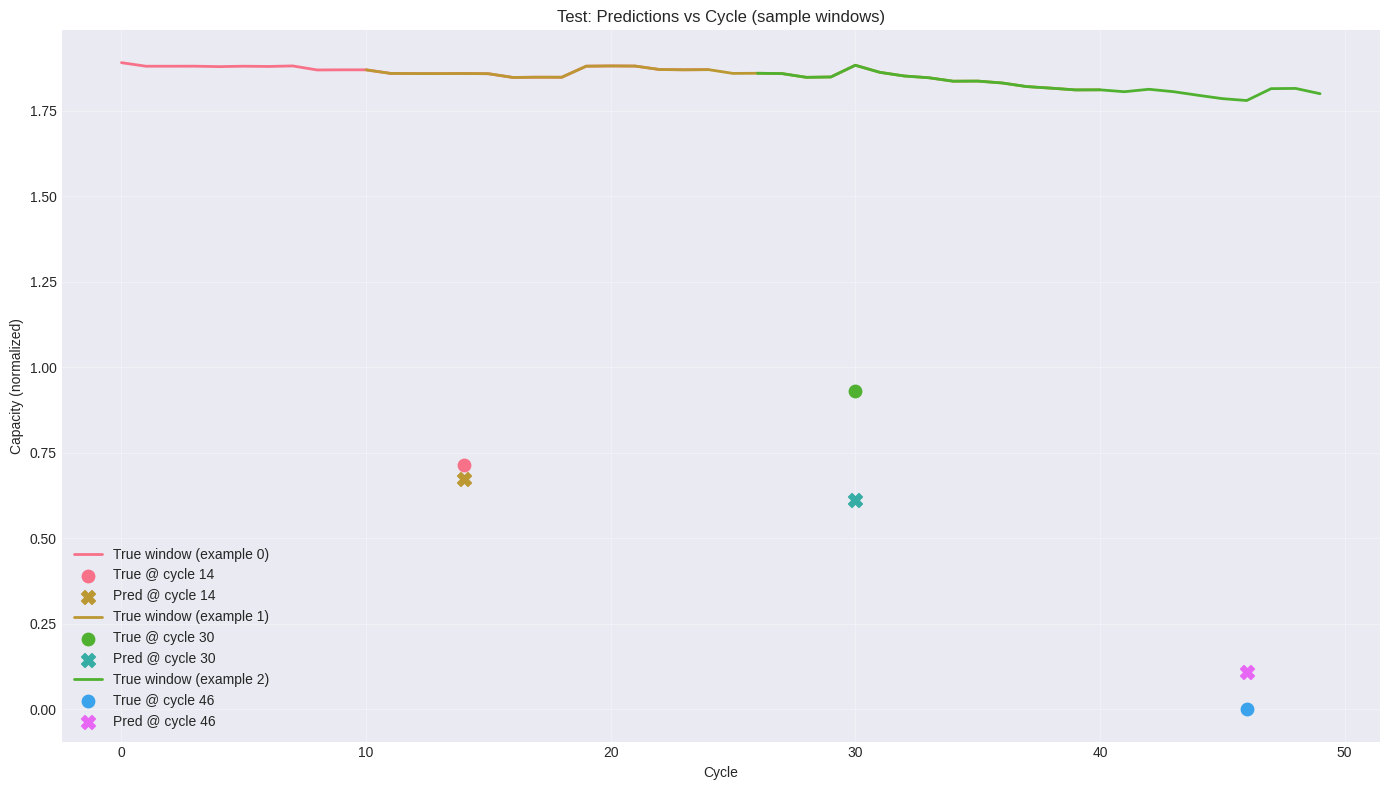


Plotting test predictions for B0007 SOC 70% (samples: 61)


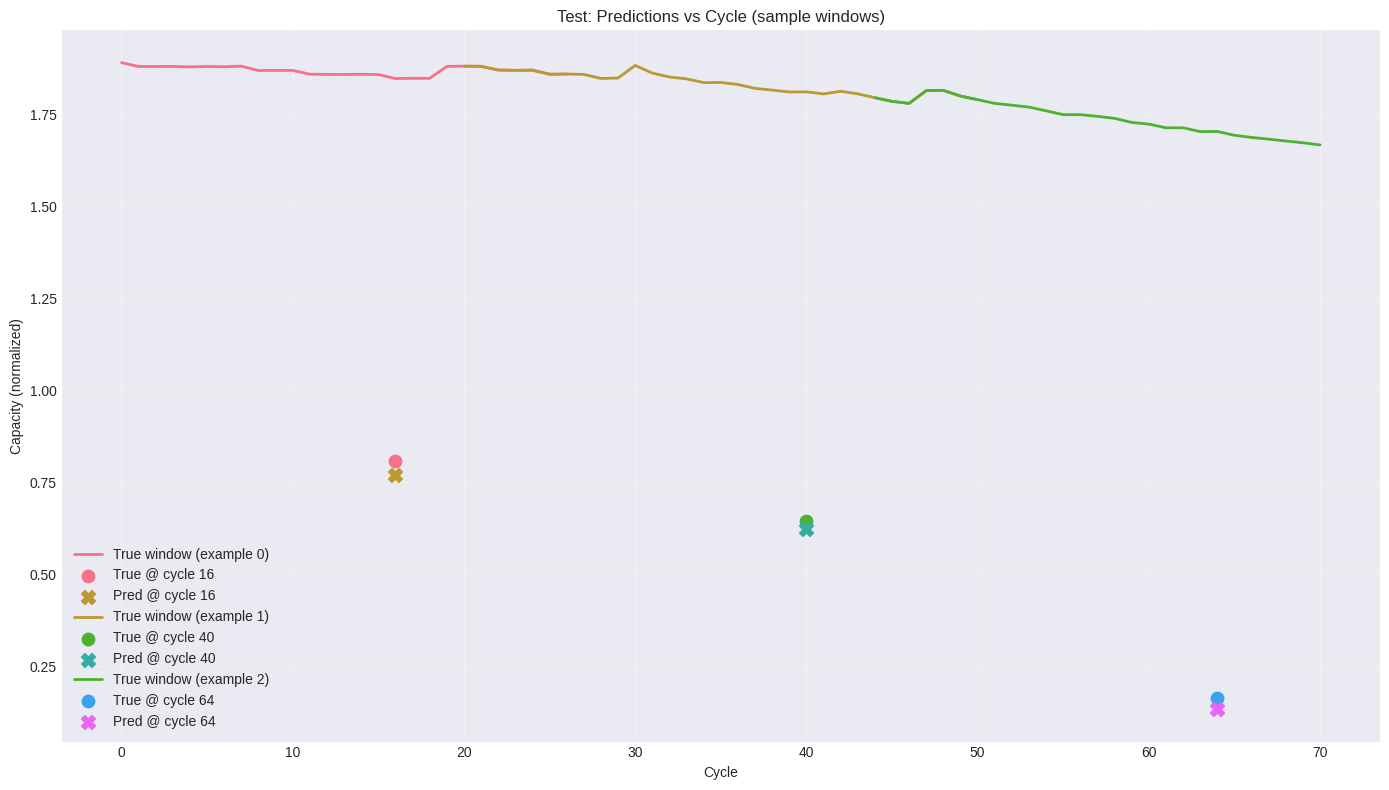


Plotting test predictions for B0007 SOC 90% (samples: 82)


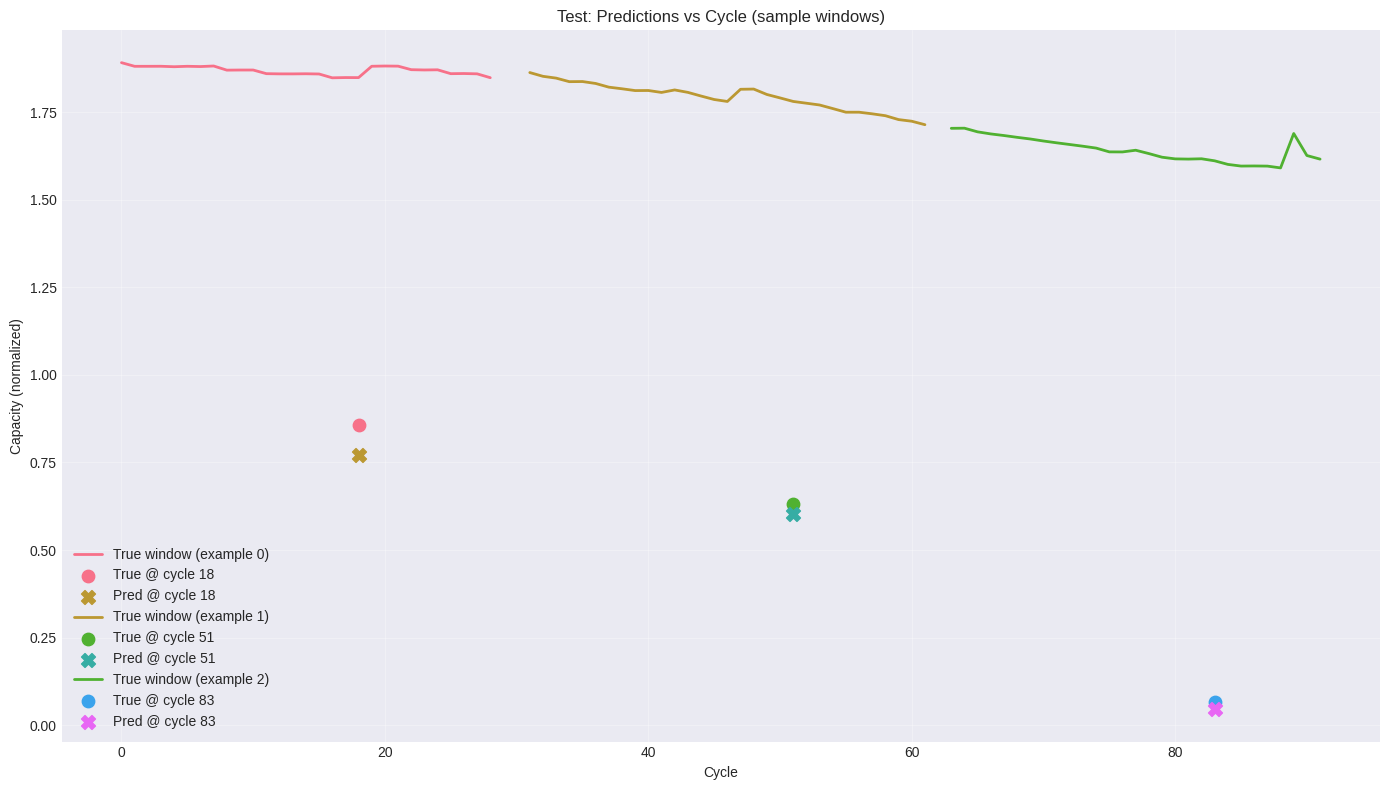

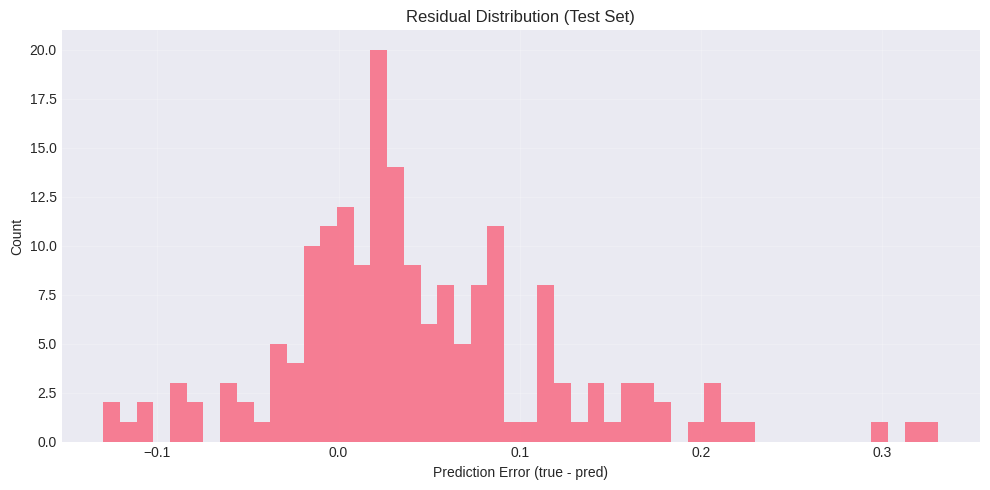

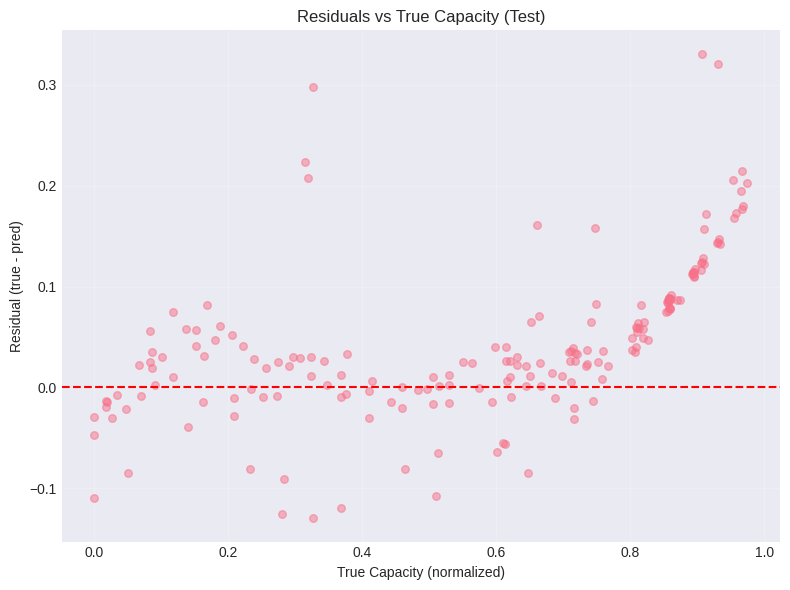


Per-SOC Test Metrics (B7):
 SOC  Samples     RMSE      MAE       R2
  50       40 0.113083 0.083271 0.800722
  70       61 0.074342 0.051512 0.931711
  90       82 0.084056 0.062496 0.929318

✓ Per-SOC metrics saved to 'per_soc_test_metrics.csv'


In [27]:

print("\n" + "="*80)
print("ADDITIONAL VISUALIZATIONS: PREDICTIONS vs CYCLE, RESIDUALS, PER-SOC METRICS")
print("="*80)

# Helper to plot predictions over cycles for a selection of SOCs from test battery
def plot_predictions_over_cycles(X_sequences, y_true, y_pred, original_df, seq_length=seq_length, n_examples=3, title_prefix='Test'):
    """
    X_sequences: sequence input array (N, seq_length, features)
    y_true, y_pred: arrays of scalar (length N)
    original_df: original unscaled dataframe for that SOC used to build sequences
    """
    N = len(y_true)
    # pick a few random indices but constrained to early/mid/late phases
    idxs = [int(N*0.1), int(N*0.5), int(N*0.9)]
    plt.figure(figsize=(14, 8))

    for i, idx in enumerate(idxs[:n_examples]):
        # map sequence end to cycle index in original df: sequence ends at idx + seq_length
        cycle_idx = idx + seq_length
        # show local window of cycles
        start = max(0, cycle_idx - seq_length - 10)
        end = min(len(original_df)-1, cycle_idx + 10)
        cycles = np.arange(start, end + 1)

        # true capacity from original df for that window
        true_window = original_df['capacity'].values[start:end+1]

        # predicted scalar belongs to point cycle_idx
        pred_point = y_pred[idx]
        true_point = y_true[idx]

        plt.plot(cycles, true_window, label=f'True window (example {i})', linewidth=2)
        plt.scatter([cycle_idx], [true_point], marker='o', s=80, label=f'True @ cycle {cycle_idx}')
        plt.scatter([cycle_idx], [pred_point], marker='X', s=100, label=f'Pred @ cycle {cycle_idx}')

    plt.xlabel('Cycle')
    plt.ylabel('Capacity (normalized)')
    plt.title(f'{title_prefix}: Predictions vs Cycle (sample windows)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot examples from each SOC in test battery (B7)
for soc in loader.soc_levels:
    df_test = battery_data[test_battery][soc].copy()
    scaler = [t['scaler'] for t in test_info if t['soc'] == soc][0]
    # Build sequences same way as used earlier (must match prepare_sequences on scaled df)
    df_scaled = df_test.copy()
    df_scaled[['capacity']] = scaler.transform(df_scaled[['capacity']])
    X_seq, y_seq = loader.prepare_sequences(df_scaled, seq_length=seq_length, feature_cols=['capacity'])
    # find indices in global X_test matching this SOC (simple approach: use ordering used in prepare_multi_battery_data)
    # We'll slice from local arrays: we previously concatenated test sequences in the prepare function in SOC order,
    # so we can reconstruct lengths per SOC from test_info.
    soc_entry = next((t for t in test_info if t['soc'] == soc), None)
    if soc_entry is None:
        continue
    samples = soc_entry['samples']
    # compute offset
    offset = sum([t['samples'] for t in test_info if t['soc'] < soc])
    y_true_local = y_test[offset:offset+samples]
    y_pred_local = y_pred_test[offset:offset+samples]
    print(f"\nPlotting test predictions for {test_battery} SOC {soc}% (samples: {samples})")
    plot_predictions_over_cycles(None, y_true_local, y_pred_local, df_test, seq_length=seq_length)

# Residual analysis aggregated
residuals_test = y_test - y_pred_test
plt.figure(figsize=(10,5))
plt.hist(residuals_test, bins=50, alpha=0.9)
plt.title('Residual Distribution (Test Set)')
plt.xlabel('Prediction Error (true - pred)')
plt.ylabel('Count')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Residuals vs True
plt.figure(figsize=(8,6))
plt.scatter(y_test, residuals_test, alpha=0.5, s=30)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Capacity (normalized)')
plt.ylabel('Residual (true - pred)')
plt.title('Residuals vs True Capacity (Test)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Per-SOC performance table for the test battery
per_soc_rows = []
offset = 0
for entry in test_info:
    n = entry['samples']
    if n == 0:
        per_soc_rows.append({
            'SOC': entry['soc'],
            'Samples': 0,
            'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan
        })
        continue
    y_t = y_test[offset:offset+n]
    y_p = y_pred_test[offset:offset+n]
    m = calculate_metrics(y_t, y_p)
    per_soc_rows.append({
        'SOC': entry['soc'],
        'Samples': n,
        'RMSE': m['RMSE'],
        'MAE': m['MAE'],
        'R2': m['R2']
    })
    offset += n

per_soc_df = pd.DataFrame(per_soc_rows)
print("\nPer-SOC Test Metrics (B7):")
print(per_soc_df.to_string(index=False))
per_soc_df.to_csv('per_soc_test_metrics.csv', index=False)
print("\n✓ Per-SOC metrics saved to 'per_soc_test_metrics.csv'")


SIMPLE EXPLAINABILITY / SENSITIVITY


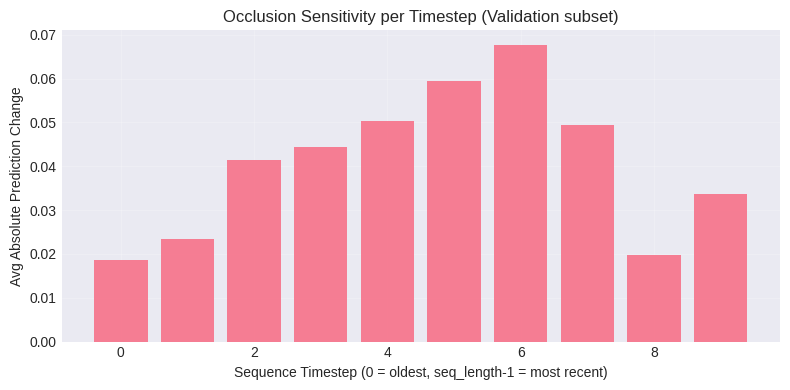

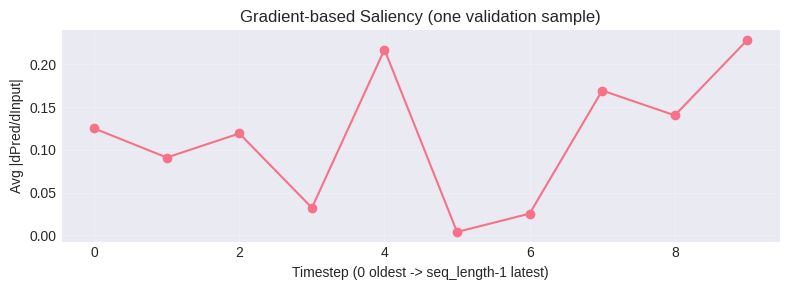

In [28]:

print("\n" + "="*80)
print("SIMPLE EXPLAINABILITY / SENSITIVITY")
print("="*80)

# 1) Occlusion sensitivity (for capacity-only sequences: zero-out one timestep and measure effect)
def occlusion_sensitivity(model, X, idx_to_occlude=0, baseline=0.0):
    X_occ = X.copy()
    X_occ[:, idx_to_occlude, :] = baseline
    y_base = model.predict(X, verbose=0).flatten()
    y_occ = model.predict(X_occ, verbose=0).flatten()
    impact = np.abs(y_base - y_occ)
    return impact

# compute average impact per timestep on a subset of validation data
sample_X = X_val[:200] if len(X_val) > 200 else X_val
timesteps = sample_X.shape[1]
avg_impacts = []
for t in range(timesteps):
    impact = occlusion_sensitivity(model, sample_X, idx_to_occlude=t, baseline=0.0)
    avg_impacts.append(impact.mean())

plt.figure(figsize=(8,4))
plt.bar(np.arange(timesteps), avg_impacts, alpha=0.9)
plt.xlabel('Sequence Timestep (0 = oldest, seq_length-1 = most recent)')
plt.ylabel('Avg Absolute Prediction Change')
plt.title('Occlusion Sensitivity per Timestep (Validation subset)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 2) Gradient-based saliency (simple input gradient for a sample)
# NOTE: requires TF2 eager - compute for one validation example
import tensorflow as tf
if hasattr(tf, 'GradientTape'):
    sample = tf.convert_to_tensor(X_val[0:1], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(sample)
        pred = model(sample, training=False)
    grads = tape.gradient(pred, sample).numpy()[0]  # shape seq_length x features
    # aggregate per timestep
    grads_abs = np.mean(np.abs(grads), axis=1)
    plt.figure(figsize=(8,3))
    plt.plot(grads_abs, marker='o')
    plt.xlabel('Timestep (0 oldest -> seq_length-1 latest)')
    plt.ylabel('Avg |dPred/dInput|')
    plt.title('Gradient-based Saliency (one validation sample)')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    print("GradientTape not available in this TF build — skipping gradient saliency.")


In [ ]:
print("\n" + "="*80)
print("SAVING MODEL AND ARTIFACTS")
print("="*80)

# Save Keras model (HDF5 and SavedModel)
model.export('cnn_dblstm_enhanced_savedmodel')        # SavedModel dir
model.save('cnn_dblstm_enhanced.h5')               # HDF5 file
print("✓ Model saved to 'cnn_dblstm_enhanced.h5' and 'cnn_dblstm_enhanced_savedmodel/'")

# Save training history as CSV
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('training_history.csv', index=False)
print("✓ Training history saved to 'training_history.csv'")

# Save scalers for each train/test SOC using joblib
import joblib
for i, info in enumerate(train_info):
    joblib.dump(info['scaler'], f"scaler_train_{info['battery']}_SOC{info['soc']}.pkl")
for i, info in enumerate(test_info):
    joblib.dump(info['scaler'], f"scaler_test_{info['battery']}_SOC{info['soc']}.pkl")
print("✓ Scalers saved as .pkl files")

# Save a small metadata file with run information
run_meta = {
    'model_name': model.name,
    'seq_length': seq_length,
    'n_features': n_features,
    'train_batteries': train_batteries,
    'test_battery': test_battery,
    'soc_levels': loader.soc_levels,
    'total_train_samples': len(X_train),
    'total_test_samples': len(X_test),
    'date': pd.Timestamp.now().isoformat()
}
import json
with open('run_metadata.json', 'w') as f:
    json.dump(run_meta, f, indent=2)
print("✓ Run metadata saved to 'run_metadata.json'")

# If running in Colab and you want to prepare a zip of artifacts:
import shutil
shutil.make_archive('battery_model_artifacts', 'zip', root_dir='.')
print("✓ Artifacts zipped to 'battery_model_artifacts.zip'")

print("\n" + "="*80)
print("PRACTICAL NOTES & NEXT STEPS")
print("="*80)

notes = """
1) Data scaling: In this notebook each SOC used its own MinMax scaler (per-DF). For deployment, prefer
   a consistent scaling strategy (global scaler) or store and use the exact scaler used for each SOC / battery.

2) Sequence alignment: Ensure that sequence -> cycle mapping is tracked carefully when converting predictions
   back to physical cycles and computing RUL. We approximated mapping by sequence index offsets.

3) RUL ground-truth: Here RUL was derived from the capacity series and a hard failure threshold (70%).
   If you have experimentally-labeled EOL cycles use those for improved RUL ground-truth.

4) Model improvements:
   - Increase seq_length and tune Conv1D filter sizes and LSTM units.
   - Use attention after BiLSTM to allow the model to learn which timesteps matter most.
   - Add multi-feature inputs (voltage, temp, current) and use feature fusion layers.
   - Consider ensembling (e.g., CNN-DBLSTM + Transformer hybrid) for robustness.

5) Regularization & optimization:
   - Sweep dropout (0.1-0.4), L2 weight decay, learning rates (1e-4 -> 1e-3), and batch sizes.
   - Use learning rate warmup or cosine schedules for better convergence.

6) Explainability:
   - For multi-feature models use SHAP (DeepExplainer/GradientExplainer) or Integrated Gradients at inference.
   - For time-series, attention weights are a natural interpretability proxy.

7) Evaluation:
   - Evaluate RUL using additional metrics: timeliness (how early/late failure predicted), F1 on EOL detection,
     and time-to-failure MAE within last 20% cycles of life.

8) Reproducibility:
   - Save random seeds, conda/pip env, and include precise dataset versions (CSV snapshots) in artifacts.

9) Real-world considerations:
   - Battery measurement noise, seasonal temperature shifts, and varying usage profiles need to be modeled
     (data augmentation, domain adaptation).

10) Quick hyperparameter suggestions to try next (grid):
    - seq_length: [10, 20, 40]
    - Conv filters: [(32,64,96), (64,128,192)]
    - LSTM units: [16, 32, 64]
    - Learning rate: [1e-3, 5e-4, 1e-4]
    - Batch size: [16, 32, 64]

"""
print(notes)

print("\n✓ Notebook continuation finished. Files generated: ")
print("  - capacity/soh/rul figures (PNG), model files (.h5, SavedModel),")
print("  - csvs: model_performance_metrics.csv, per_soc_test_metrics.csv, rul_estimation_metrics.csv, training_history.csv")
print("  - battery_model_artifacts.zip")



SAVING MODEL AND ARTIFACTS
Saved artifact at 'cnn_dblstm_enhanced_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140306496053776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496053200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496056464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496055696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496055120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496057232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496054736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496056272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496054544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140306496056656: TensorSpec(shape=(), dtype=tf.re

✓ Model saved to 'cnn_dblstm_enhanced.h5' and 'cnn_dblstm_enhanced_savedmodel/'
✓ Training history saved to 'training_history.csv'
✓ Scalers saved as .pkl files
✓ Run metadata saved to 'run_metadata.json'
